# **Import**

*Once this cell is successfully executed you can comment on it and execute all the notebook cells at once*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
! cp /content/drive/"My Drive"/"Pascal Notsawo Summer 2020 WL Research Internship"/"Project 2: Learning with Derivatives"/"week 1"/utils.py /content
! cp /content/drive/"My Drive"/"Pascal Notsawo Summer 2020 WL Research Internship"/"Project 2: Learning with Derivatives"/"week 2"/diff_ml_utils.py /content
! cp /content/drive/"My Drive"/"Pascal Notsawo Summer 2020 WL Research Internship"/"Project 2: Learning with Derivatives"/"week 3"/twin_net.py /content

In [ ]:
try:
    %tensorflow_version 1.x
    %matplotlib inline
except Exception:
    pass

import tensorflow as tf
import torch.nn.functional as F
import torch
import numpy as np
import random

from utils import gradient, genData, plotFunction, plotGrad, get_data_loader, MLP_Relu, plot_stat
from diff_ml_utils import graph, Generator, get_diffML_data_loader, BlackScholes, Bachelier

# to avoid collision
from utils import Siren as tf_Siren
from diff_ml_utils import test as diff_ml_test # to avoid collision

from twin_net import Siren, MLP, TwinNet, train, test

TensorFlow 1.x selected.
1.15.2
False




In [ ]:
seed = 0
random.seed(seed)
np.random.seed(seed)
tf.random.set_random_seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
nTrain = 1000
nTest = 1000
train_seed, test_seed = 0, 0
batch_size = 256

learning_rate = 0.0001

max_epoch = 2000
improving_limit = 10

HIDDEN_DIM = 20
N_HIDDEN = 4

**To avoid repeating the same code too much**

In [ ]:
def batch_to_list(batchs):
    r = []
    for e in batchs :
        x = e.detach().numpy()
        for f in x :  
            r.append([f[0]])
    return np.array(r)

def run_train(name, generator, with_derivative, model_class, model_kwargs, deltidx = 0, lam = 1):
    global nTrain, nTest, train_seed, test_seed, batch_size, learning_rate
    train_dataloader, test_dataloader, xAxis, vegas, config = get_diffML_data_loader(
        generator = generator, 
        nTrain = nTrain, nTest = nTest, 
        train_seed = train_seed, test_seed = test_seed, batch_size = batch_size, with_derivative = with_derivative,
        normalize = True
    )

    model = model_class(**model_kwargs)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

    model, stats, best_loss = train(model, train_dataloader, optimizer, criterion, config, lam,
                                    with_derivative = with_derivative, max_epoch = max_epoch, 
                                    improving_limit = improving_limit)

    plot_stat(stats, with_derivative = with_derivative)

    if with_derivative :
        loss, _, _, (yTest, dydxTest, values, deltas) = test(model, test_dataloader, criterion, config, lam, 
                                                             with_derivative = with_derivative)
    else :
        loss, (yTest, values) = test(model, test_dataloader, criterion, config, lam,
                                     with_derivative = with_derivative)
    
    values =  batch_to_list(values) 
    yTest = batch_to_list(yTest) 

    values = {("standard", nTest) : values,
              #("differential", nTest) : []
            }
    try :
        graph(name, values, xAxis, "", "values", yTest, [nTest], True)
    except (KeyError, TypeError) :
        pass
  
    if with_derivative :
        deltas = batch_to_list(deltas) 
        deltas = {("standard", nTest) : deltas[:, deltidx],
                  #("differential", nTest) : []
        }
        dydxTest = batch_to_list(dydxTest) 
        try :
            graph(name, deltas, xAxis, "", "deltas", dydxTest[:, deltidx], [nTest], True)
        except (KeyError, TypeError) :
            pass
        
    return model, loss

def run_diffML_train(name, generator, generator_kwargs, show_graph_per_axis = False, input_dim = None):
    global nTrain, nTest, train_seed, test_seed
    loss, regressor, dtrain, dtest, dydxTest, values, deltas, xAxis, vegas = diff_ml_test(
          generator, [nTrain], 
          nTrain, nTest, 
          trainSeed = train_seed, testSeed = test_seed, weightSeed = 0, 
          deltidx=0,
          generator_kwargs = generator_kwargs 
          ) 

    yTest = dtest[1]
    sizes = [nTrain]
    # show predicitions
    graph(name, values, xAxis, "", "values", yTest, [nTrain], True)
    # show deltas
    graph(name, deltas, xAxis, "", "deltas", dydxTest, [nTrain], True)

    if show_graph_per_axis :
        assert input_dim
        for i in range(input_dim) :
            xAxis  = np.array([[x[i]] for x in dtest[0]])
            # show predicitions
            graph("%s x%d vs y" % (name, (i+1)), values, xAxis, "", "values", yTest, [nTrain], True)
            # show deltas
            graph("%s x%d vs dxdy" % (name, (i+1)), deltas, xAxis, "", "deltas", dydxTest, [nTrain], True)

    return regressor, loss


def run_twinNet_train(name, generator, with_derivative, model_class, model_kwargs, deltidx = 0, lam = 1):
    global nTrain, nTest, train_seed, test_seed, batch_size, learning_rate, max_epoch, improving_limit
    
    train_dataloader, test_dataloader, xAxis, vegas, config = get_diffML_data_loader(
        generator = generator, 
        nTrain = nTrain, nTest = nTest, 
        train_seed = train_seed, test_seed = test_seed, batch_size = batch_size, 
        with_derivative = with_derivative, normalize = True
    )

    model = model_class(**model_kwargs)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

    tn = TwinNet(model = model, optimizer = optimizer, criterion = criterion)

    tn.train(train_dataloader, config, lam, with_derivative, max_epoch, improving_limit)

    plot_stat(tn.stats, with_derivative)

    if with_derivative :
        loss, _, _, (yTest, dydxTest, values, deltas) = tn.test(test_dataloader, config, lam, with_derivative)
    else :
        loss, (yTest, values) = tn.test(test_dataloader, config, lam, with_derivative)
    
    values =  batch_to_list(values) 
    yTest = batch_to_list(yTest) 

    values = {("standard", nTest) : values,
              #("differential", nTest) : []
            }
    try :
        graph(name, values, xAxis, "", "values", yTest, [nTest], True)
    except (KeyError, TypeError) :
        pass
  
    if with_derivative :
        deltas = batch_to_list(deltas) 
        deltas = {("standard", nTest) : deltas[:, deltidx],
                  #("differential", nTest) : []
        }
        dydxTest = batch_to_list(dydxTest) 
        try :
            graph(name, deltas, xAxis, "", "deltas", dydxTest[:, deltidx], [nTest], True)
        except (KeyError, TypeError) :
            pass
        
    return tn, loss

# **1) Black & Scholes**

In [ ]:
INPUT_DIM = 1

generator = BlackScholes()
graph_name = "Black & Scholes"

## **1.1) Normal Training**

Epoch 0: train loss: 1.0076669454574585
Epoch 1: train loss: 1.007182002067566
Epoch 2: train loss: 1.006715714931488
Epoch 3: train loss: 1.0062675923109055
Epoch 4: train loss: 1.0058376789093018
Epoch 5: train loss: 1.0054261088371277
Epoch 6: train loss: 1.0050334632396698
Epoch 7: train loss: 1.0046593099832535
Epoch 8: train loss: 1.0043028593063354
Epoch 9: train loss: 1.0039597749710083
Epoch 10: train loss: 1.003632128238678
Epoch 11: train loss: 1.0033203214406967
Epoch 12: train loss: 1.0030232071876526
Epoch 13: train loss: 1.0027386993169785
Epoch 14: train loss: 1.0024655163288116
Epoch 15: train loss: 1.0022050440311432
Epoch 16: train loss: 1.0019560009241104
Epoch 17: train loss: 1.001717284321785
Epoch 18: train loss: 1.0014866292476654
Epoch 19: train loss: 1.0012604892253876
Epoch 20: train loss: 1.0010419189929962
Epoch 21: train loss: 1.000830888748169
Epoch 22: train loss: 1.0006289631128311
Epoch 23: train loss: 1.0004353374242783
Epoch 24: train loss: 1.0002525

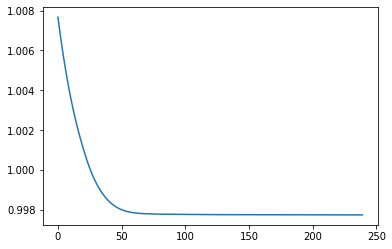

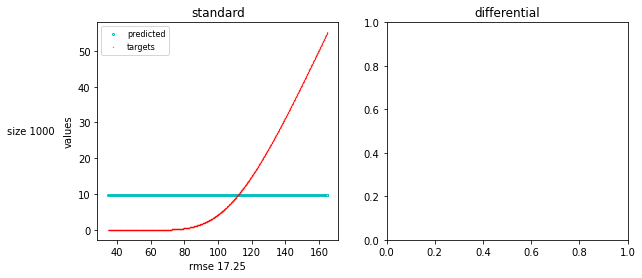

In [ ]:
model, loss = run_train(
          name = graph_name,
          generator = generator, with_derivative = False, 
          model_class = MLP_Relu, 
          model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, 
                          "hidden_layers" : N_HIDDEN, "out_features": 1}
)

## **1.2) Sobolev Training**

In [ ]:
model, loss = run_train(
          name = graph_name,
          generator = generator, with_derivative = True, 
          model_class = MLP_Relu, 
          model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, 
                          "hidden_layers" : N_HIDDEN, "out_features": 1}
)

NameError: ignored

## **1.3) SIREN**

Epoch 0: train loss: 1.3238332958931276, y loss : 0.9990578293800354, dy loss : 1.6486087624062198
Epoch 1: train loss: 1.177377650615935, y loss : 0.9980292171239853, dy loss : 1.3567260841078848
Epoch 2: train loss: 1.1040447791213057, y loss : 0.9978713840246201, dy loss : 1.2102181742179916
Epoch 3: train loss: 1.0724749871276864, y loss : 0.9978345185518265, dy loss : 1.1471154557035463
Epoch 4: train loss: 1.0584946961902308, y loss : 0.9977893829345703, dy loss : 1.1192000094458916
Epoch 5: train loss: 1.0510899927251405, y loss : 0.9977487027645111, dy loss : 1.10443128268577
Epoch 6: train loss: 1.0463541855633185, y loss : 0.997722938656807, dy loss : 1.09498543246983
Epoch 7: train loss: 1.0434232324432713, y loss : 0.9977096021175385, dy loss : 1.0891368627690043
Epoch 8: train loss: 1.0421966659619044, y loss : 0.9977011829614639, dy loss : 1.086692148962345
Epoch 9: train loss: 1.042498842503674, y loss : 0.9976921081542969, dy loss : 1.0873055768530513
Epoch 10: train lo

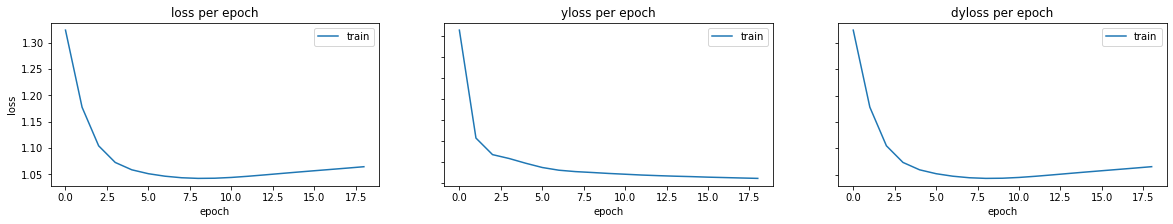

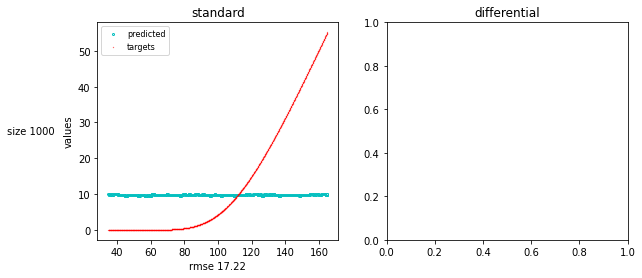

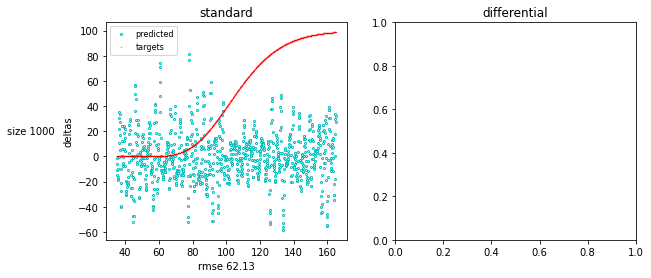

In [ ]:
model, loss = run_train(
          name = graph_name,
          generator = generator, with_derivative = True, 
          model_class = tf_Siren, 
          model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, 
                          "hidden_layers" : N_HIDDEN, "out_features": 1,
                          "outermost_linear" : True}
)

## **1.4) Differential ML**

simulating training, valid and test sets
done
initializing neural appropximator
done

size 1000



standard_yloss : 1.924004e-05
standard_dyloss : 0.0013194449
differential_yloss : 5.1535235e-06
differential_dyloss : 0.0006442806
[[1.924004e-05], [0.0013194449], [5.1535235e-06], [0.0006442806]]


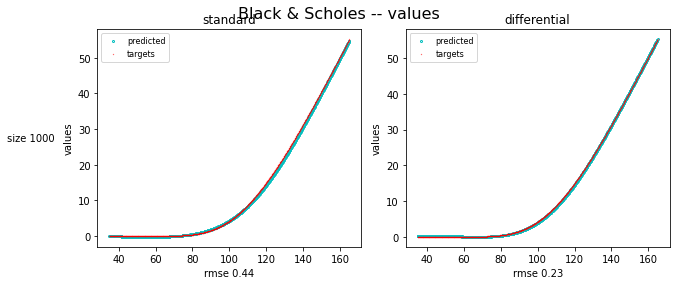

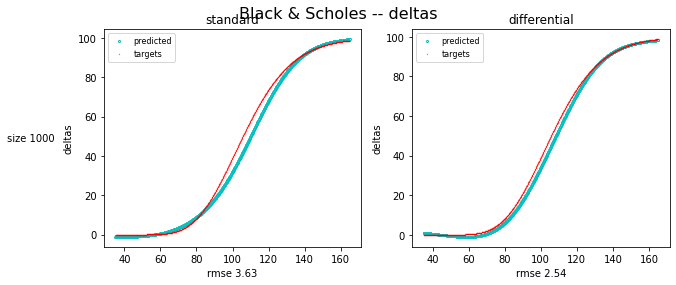

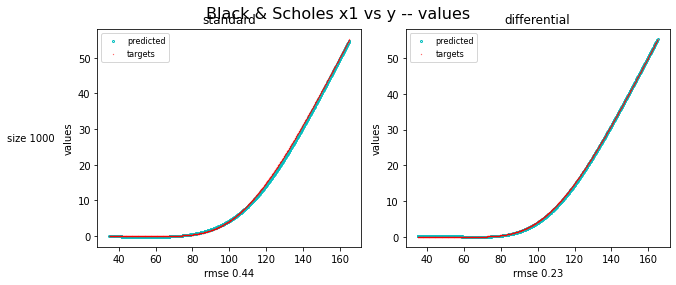

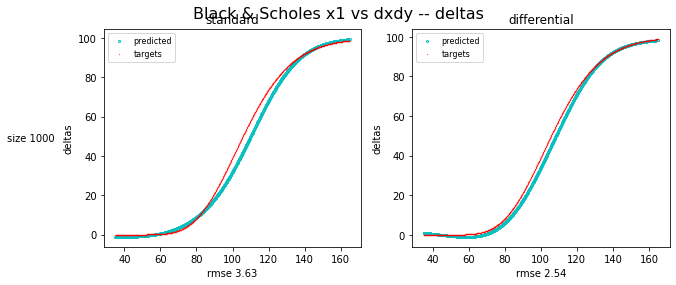

In [ ]:
model, loss = run_diffML_train(
              name = graph_name, 
              generator = generator, 
              generator_kwargs = {"hidden_units" : HIDDEN_DIM, "hidden_layers" : N_HIDDEN},
              show_graph_per_axis = True, 
              input_dim = INPUT_DIM)

## **1.5) twin_net with siren**

In [ ]:
model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, "hidden_layers" : N_HIDDEN, 
                "out_features": 1, "outermost_linear" : False, "first_omega_0" : 30, "hidden_omega_0" : 30.}

### ***1.5.1) not_with_derivative***

Epoch 0: train loss: 11.29605770111084
Epoch 1: train loss: 4.357765197753906
Epoch 2: train loss: 1.6609968841075897
Epoch 3: train loss: 1.1693560034036636
Epoch 4: train loss: 1.2499209940433502
Epoch 5: train loss: 1.201936811208725
Epoch 6: train loss: 1.0969212800264359
Epoch 7: train loss: 1.0965344607830048
Epoch 8: train loss: 1.1024814546108246
Epoch 9: train loss: 1.0613612085580826
Epoch 10: train loss: 1.0421774685382843
Epoch 11: train loss: 1.0422582924365997
Epoch 12: train loss: 1.03306944668293
Epoch 13: train loss: 1.023901641368866
Epoch 14: train loss: 1.0216797143220901
Epoch 15: train loss: 1.018330231308937
Epoch 16: train loss: 1.0140059292316437
Epoch 17: train loss: 1.012009710073471
Epoch 18: train loss: 1.0105933398008347
Epoch 19: train loss: 1.0089247524738312
Epoch 20: train loss: 1.0078565627336502
Epoch 21: train loss: 1.0070861726999283
Epoch 22: train loss: 1.0062478333711624
Epoch 23: train loss: 1.005595624446869
Epoch 24: train loss: 1.00508597493

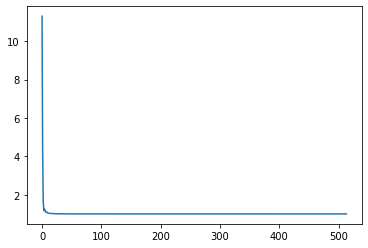

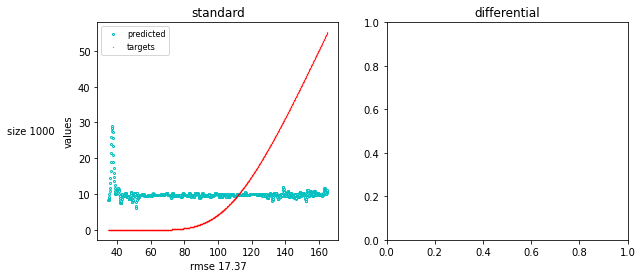

In [ ]:
with_derivative = False
twinNet, loss = run_twinNet_train(graph_name, generator, with_derivative, model_class = Siren, model_kwargs = model_kwargs, deltidx = 0)

###***1.5.2) with_derivative***

Epoch 0: train loss: 10263.556245520234, y loss : 1.2033074796199799, dy loss : 20525.90918356085
Epoch 1: train loss: 9350.867921885649, y loss : 1.0748703181743622, dy loss : 18700.660973453123
Epoch 2: train loss: 8488.02806482864, y loss : 1.043420284986496, dy loss : 16975.012709372295
Epoch 3: train loss: 7739.012376756384, y loss : 1.0222433805465698, dy loss : 15477.00251013222
Epoch 4: train loss: 7318.33487259123, y loss : 1.014836311340332, dy loss : 14635.65490887112
Epoch 5: train loss: 7049.790781359884, y loss : 1.0106919258832932, dy loss : 14098.570870793885
Epoch 6: train loss: 6885.797930318561, y loss : 1.0058787018060684, dy loss : 13770.589981935316
Epoch 7: train loss: 6744.1627681131, y loss : 1.0044750273227692, dy loss : 13487.321061198878
Epoch 8: train loss: 6565.562483871264, y loss : 1.0025240033864975, dy loss : 13130.122443739141
Epoch 9: train loss: 6408.440480258316, y loss : 1.0017447173595428, dy loss : 12815.879215799272
Epoch 10: train loss: 6286.0

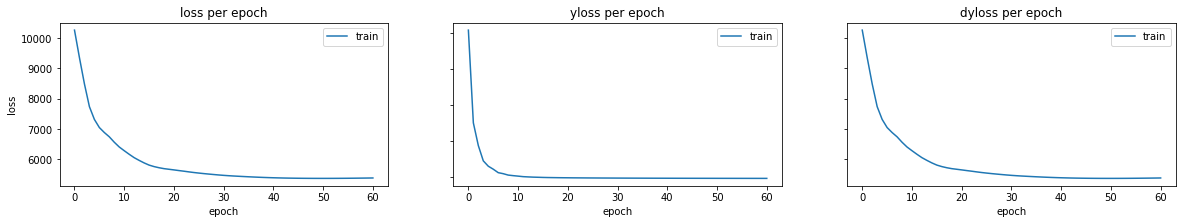

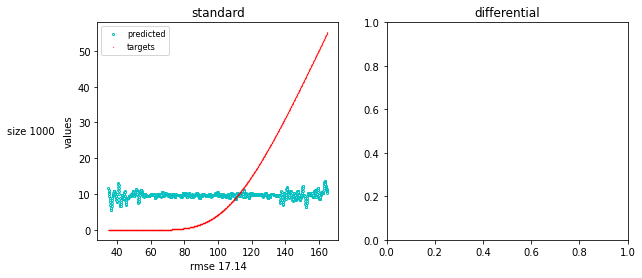

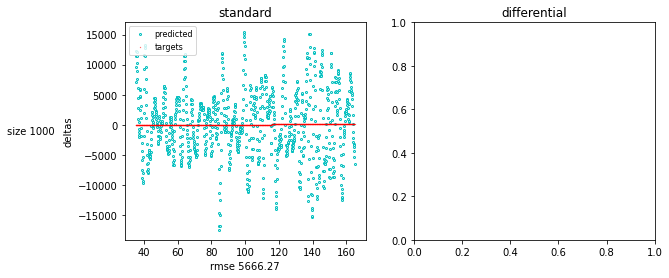

In [ ]:
with_derivative = True 
twinNet, loss = run_twinNet_train(graph_name, generator, with_derivative, model_class = Siren, model_kwargs = model_kwargs, deltidx = 0)

## **1.6) twin_net with MLP**



In [ ]:
model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, "hidden_layers" : N_HIDDEN, 
                "out_features": 1, 
                "activation_function" : F.softplus, # This is what was done in the original code.
                "deriv_activation_function" : F.sigmoid
                }
              

###***1.6.1) not_with_derivative***

In [ ]:
with_derivative = False
twinNet, loss = run_twinNet_train(graph_name, generator, with_derivative, model_class = MLP, model_kwargs = model_kwargs, deltidx = 0)

###***1.6.2) with_derivative***

Epoch 0: train loss: 0.9996231660552068, y loss : 0.999920836516789, dy loss : 0.9993254955936243
Epoch 1: train loss: 0.9991981771829727, y loss : 0.9992220091576479, dy loss : 0.9991743452082958
Epoch 2: train loss: 0.9991045550415613, y loss : 0.9992060418031654, dy loss : 0.9990030682799569
Epoch 3: train loss: 0.9990391000573051, y loss : 0.9991924671494231, dy loss : 0.9988857329651869
Epoch 4: train loss: 0.9990143367066875, y loss : 0.9991805912280569, dy loss : 0.9988480821853193
Epoch 5: train loss: 0.9990369828368031, y loss : 0.9991665713641108, dy loss : 0.9989073943094962
Epoch 6: train loss: 0.9991036759869156, y loss : 0.9991634396874175, dy loss : 0.999043912286414
Epoch 7: train loss: 0.9991890516277303, y loss : 0.9991452657446569, dy loss : 0.9992328375108035
Epoch 8: train loss: 0.999263437771404, y loss : 0.9991266040169463, dy loss : 0.9994002715258626
Epoch 9: train loss: 0.9993974833843046, y loss : 0.9991264172962734, dy loss : 0.9996685494723352
Epoch 10: tra

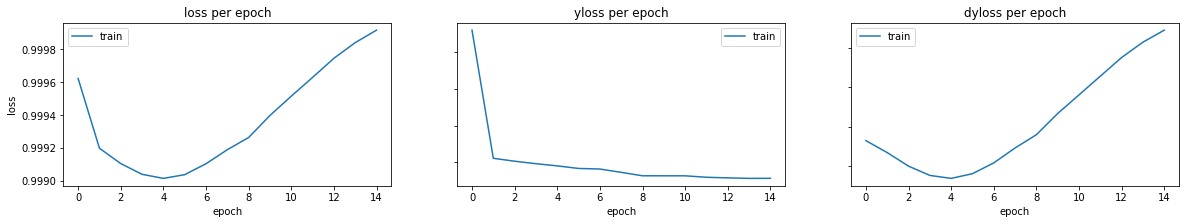

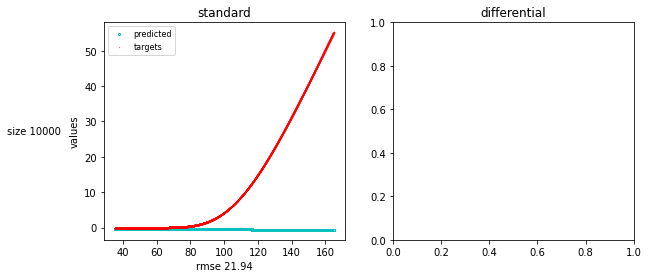

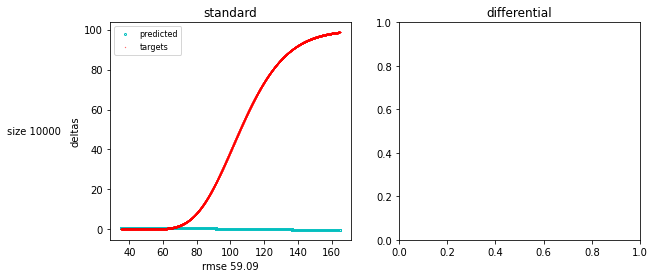

In [ ]:
with_derivative = True
twinNet, loss = run_twinNet_train(graph_name, generator, with_derivative, model_class = MLP, model_kwargs = model_kwargs, deltidx = 0)

# **2) Gaussian basket options**

## **2.1) Bachelier dimension 1**

In [ ]:
INPUT_DIM = 1
generator = Bachelier(n = INPUT_DIM)
graph_name = "Bachelier dimension %d" % INPUT_DIM

### **2.1.1) Normal Training**

Epoch 0: train loss: 0.008020958863198757
Epoch 1: train loss: 0.007660524919629097
Epoch 2: train loss: 0.007907038554549217
Epoch 3: train loss: 0.007752489298582077
Epoch 4: train loss: 0.007601199205964804
Epoch 5: train loss: 0.007643465418368578
Epoch 6: train loss: 0.007733690552413464
Epoch 7: train loss: 0.007715185638517141
Epoch 8: train loss: 0.007632829248905182
Epoch 9: train loss: 0.0075929779559373856
Epoch 10: train loss: 0.007626036182045937
Epoch 11: train loss: 0.007669345010071993
Epoch 12: train loss: 0.00766328489407897
Epoch 13: train loss: 0.007621437776833773
Epoch 14: train loss: 0.007593819405883551
Epoch 15: train loss: 0.007604497484862804
Epoch 16: train loss: 0.007630659267306328
Epoch 17: train loss: 0.00763675244525075
Epoch 18: train loss: 0.007617184426635504
Epoch 19: train loss: 0.007596148643642664
test loss: 0.013049558736383915


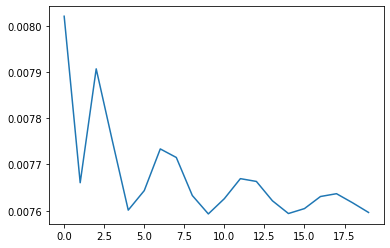

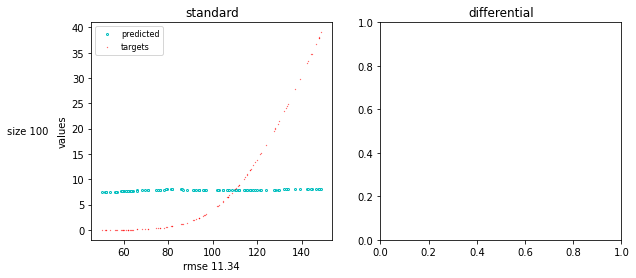

In [ ]:
model, loss = run_train(
          name = graph_name,
          generator = generator, with_derivative = False, 
          model_class = MLP_Relu, 
          model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, 
                          "hidden_layers" : N_HIDDEN, "out_features": 1}
)

### **2.1.2) Sobolev Training**

Epoch 0: train loss: 0.2602868378162384, y loss : 0.012000730261206627, dy loss : 0.24828609824180603
Epoch 1: train loss: 0.24359771609306335, y loss : 0.009429100900888443, dy loss : 0.2341686189174652
Epoch 2: train loss: 0.23097310960292816, y loss : 0.008065971545875072, dy loss : 0.2229071408510208
Epoch 3: train loss: 0.22038455307483673, y loss : 0.00784237775951624, dy loss : 0.21254217624664307
Epoch 4: train loss: 0.21137447655200958, y loss : 0.008637280203402042, dy loss : 0.20273719727993011
Epoch 5: train loss: 0.20311656594276428, y loss : 0.010277602821588516, dy loss : 0.19283896684646606
Epoch 6: train loss: 0.19580373167991638, y loss : 0.012569304555654526, dy loss : 0.18323442339897156
Epoch 7: train loss: 0.19052201509475708, y loss : 0.015316502191126347, dy loss : 0.1752055138349533
Epoch 8: train loss: 0.185594379901886, y loss : 0.018283434212207794, dy loss : 0.1673109382390976
Epoch 9: train loss: 0.18157605826854706, y loss : 0.021235952153801918, dy loss 

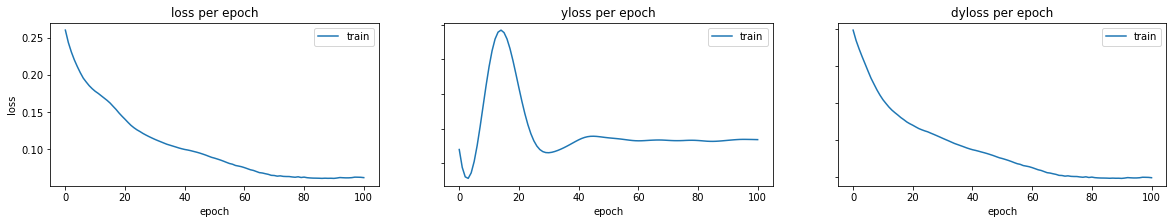

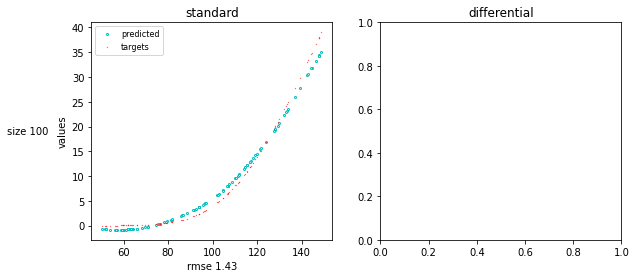

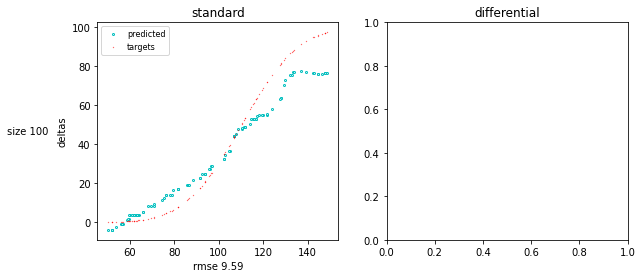

In [ ]:
model, loss = run_train(
          name = graph_name,
          generator = generator, with_derivative = True, 
          model_class = MLP_Relu, 
          model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, 
                          "hidden_layers" : N_HIDDEN, "out_features": 1}
)

### **2.1.3) SIREN**

Epoch 0: train loss: 0.6118337512016296, y loss : 0.007969803176820278, dy loss : 0.6038639545440674
Epoch 1: train loss: 5.739339828491211, y loss : 0.010970539413392544, dy loss : 5.728369235992432
Epoch 2: train loss: 1.1082148551940918, y loss : 0.009179220534861088, dy loss : 1.099035620689392
Epoch 3: train loss: 0.4784698188304901, y loss : 0.008357971906661987, dy loss : 0.4701118469238281
Epoch 4: train loss: 0.7445235848426819, y loss : 0.009089472703635693, dy loss : 0.7354341149330139
Epoch 5: train loss: 0.5710973739624023, y loss : 0.00922809261828661, dy loss : 0.5618692636489868
Epoch 6: train loss: 0.21788260340690613, y loss : 0.009222732856869698, dy loss : 0.20865987241268158
Epoch 7: train loss: 0.3706819415092468, y loss : 0.009468697011470795, dy loss : 0.36121323704719543
Epoch 8: train loss: 0.44671809673309326, y loss : 0.009485084563493729, dy loss : 0.43723300099372864
Epoch 9: train loss: 0.2916854918003082, y loss : 0.009327772073447704, dy loss : 0.282357

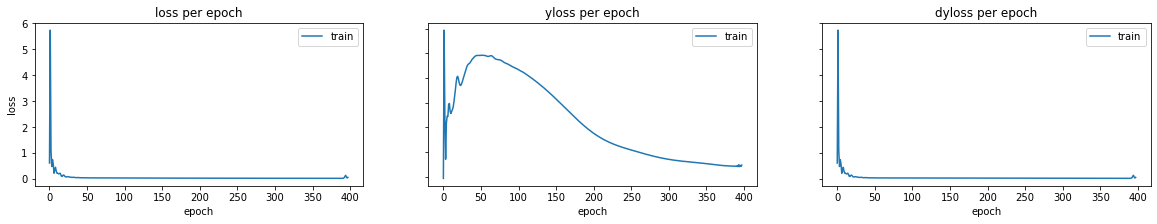

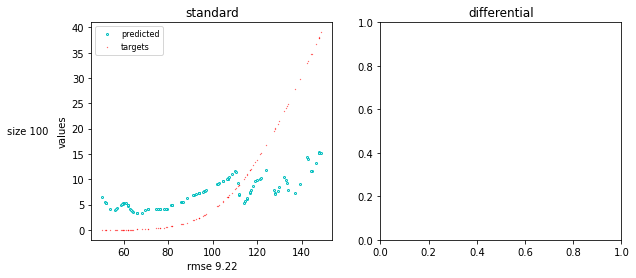

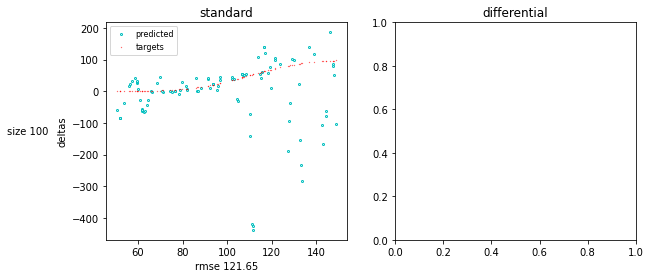

In [ ]:
model, loss = run_train(
          name = graph_name,
          generator = generator, with_derivative = True, 
          model_class = tf_Siren, 
          model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, 
                          "hidden_layers" : N_HIDDEN, "out_features": 1,
                          "outermost_linear" : True}
)

### **2.1.4) Differential ML**

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100



standard_yloss : 0.008001061
standard_dyloss : 0.22420095
differential_yloss : 7.561495e-06
differential_dyloss : 0.00081203674
[[0.008001061], [0.22420095], [7.561495e-06], [0.00081203674]]


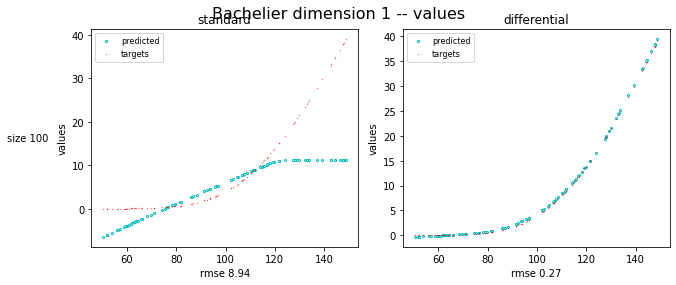

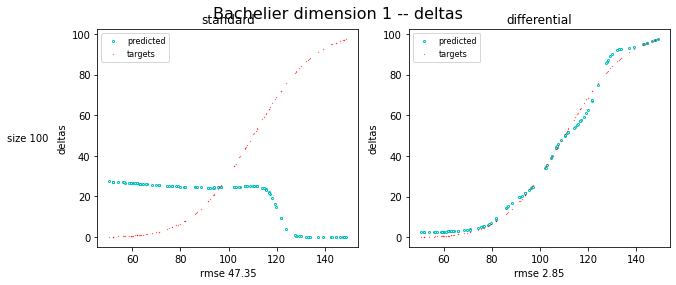

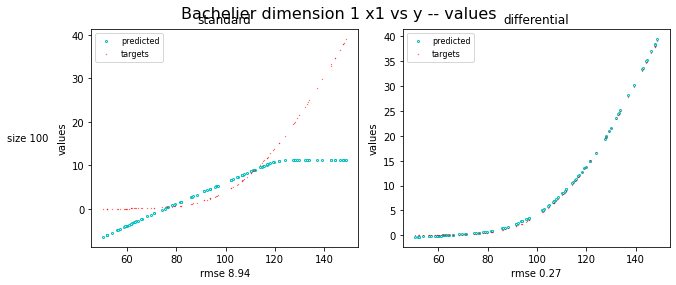

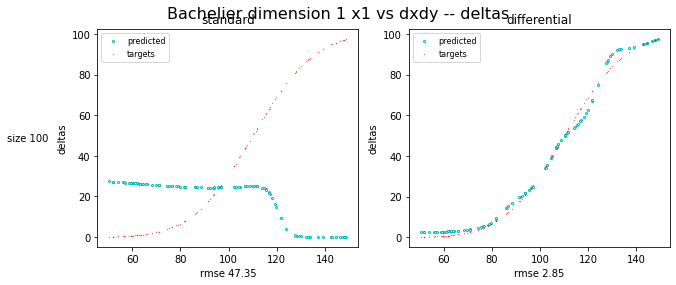

In [ ]:
model, loss = run_diffML_train(
              name = graph_name, 
              generator = generator, 
              generator_kwargs = {"hidden_units" : HIDDEN_DIM, "hidden_layers" : N_HIDDEN},
              show_graph_per_axis = True, 
              input_dim = INPUT_DIM)

### **2.1.5) twin_net with siren**

Epoch 0: train loss: 860.0404052734375, y loss : 0.36063021421432495, dy loss : 859.6797485351562
Epoch 1: train loss: 1118.6090087890625, y loss : 15.9330472946167, dy loss : 1102.6759033203125
Epoch 2: train loss: 873.0442504882812, y loss : 2.8858726024627686, dy loss : 870.1583862304688
Epoch 3: train loss: 944.311279296875, y loss : 3.7485053539276123, dy loss : 940.562744140625
Epoch 4: train loss: 947.0391845703125, y loss : 1.8815845251083374, dy loss : 945.1575927734375
Epoch 5: train loss: 995.9083862304688, y loss : 1.1432541608810425, dy loss : 994.76513671875
Epoch 6: train loss: 1329.7110595703125, y loss : 1.8433314561843872, dy loss : 1327.86767578125
Epoch 7: train loss: 1654.5439453125, y loss : 1.3211214542388916, dy loss : 1653.2227783203125
Epoch 8: train loss: 1887.1343994140625, y loss : 0.5496196746826172, dy loss : 1886.5848388671875
Epoch 9: train loss: 2084.690185546875, y loss : 0.7407059073448181, dy loss : 2083.949462890625
Epoch 10: train loss: 2254.73413

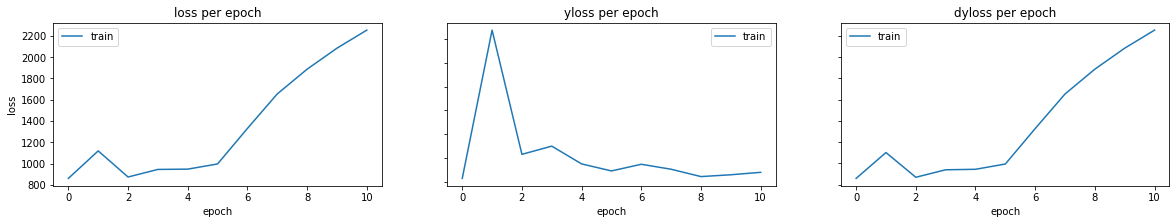

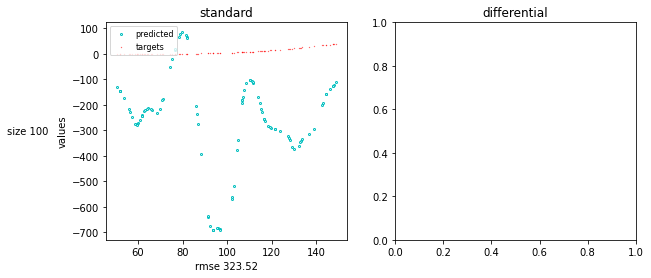

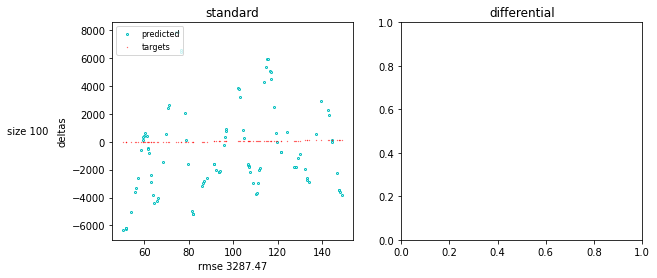

In [ ]:
model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, "hidden_layers" : N_HIDDEN, 
                "out_features": 1, "outermost_linear" : False, "first_omega_0" : 30, "hidden_omega_0" : 30.}

with_derivative = True      
twinNet, loss = run_twinNet_train(graph_name, generator, with_derivative, model_class = Siren, model_kwargs = model_kwargs, deltidx = 0)

### **2.1.6) twin_net with MLP**

Epoch 0: train loss: 0.30251607298851013, y loss : 0.022908389568328857, dy loss : 0.2796076834201813
Epoch 1: train loss: 0.2898102402687073, y loss : 0.009115624241530895, dy loss : 0.2806946039199829
Epoch 2: train loss: 0.2999081015586853, y loss : 0.01881006918847561, dy loss : 0.28109803795814514
Epoch 3: train loss: 0.29494714736938477, y loss : 0.01412351056933403, dy loss : 0.28082364797592163
Epoch 4: train loss: 0.28842800855636597, y loss : 0.008108306676149368, dy loss : 0.2803196907043457
Epoch 5: train loss: 0.28885483741760254, y loss : 0.009021650068461895, dy loss : 0.27983319759368896
Epoch 6: train loss: 0.2921659052371979, y loss : 0.012630592100322247, dy loss : 0.27953532338142395
Epoch 7: train loss: 0.2920265197753906, y loss : 0.012555859051644802, dy loss : 0.27947065234184265
Epoch 8: train loss: 0.28916582465171814, y loss : 0.009584564715623856, dy loss : 0.2795812487602234
Epoch 9: train loss: 0.28742605447769165, y loss : 0.007645606994628906, dy loss : 

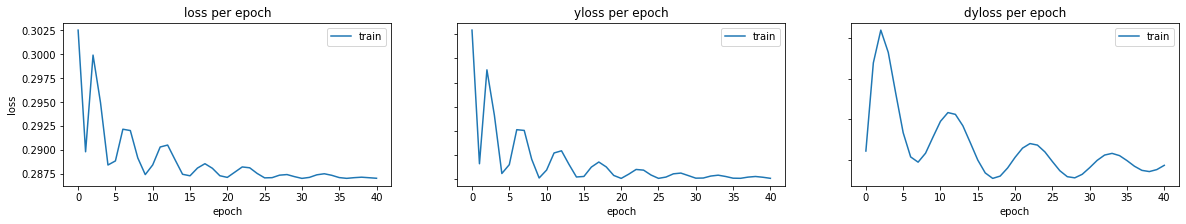

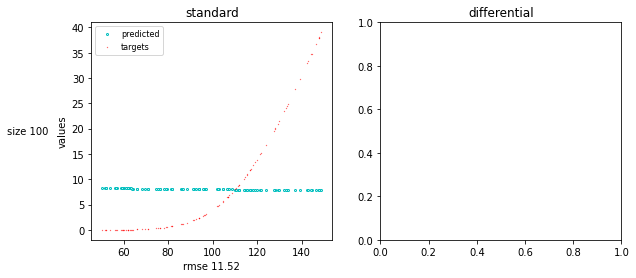

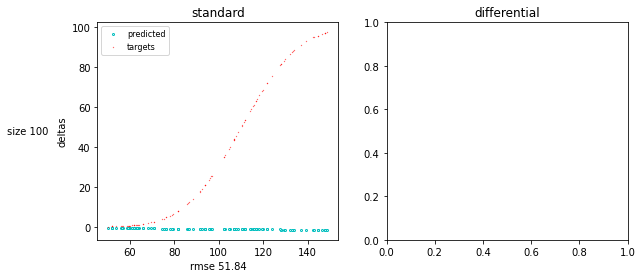

In [ ]:
model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, "hidden_layers" : N_HIDDEN, 
                "out_features": 1, 
                "activation_function" : F.softplus, # This is what was done in the original code.
                "deriv_activation_function" : F.sigmoid
                }
                
with_derivative = True
twinNet, loss = run_twinNet_train(graph_name, generator, with_derivative, model_class = MLP, model_kwargs = model_kwargs, deltidx = 0)

## **2.2) Bachelier dimension 7**

In [ ]:
INPUT_DIM = 7
generator = Bachelier(n = INPUT_DIM)
graph_name = "Bachelier dimension %d" % INPUT_DIM

### **2.2.1) Normal Training**

Epoch 0: train loss: 0.019464045763015747
Epoch 1: train loss: 0.015173264779150486
Epoch 2: train loss: 0.011899136006832123
Epoch 3: train loss: 0.009584058076143265
Epoch 4: train loss: 0.008155948482453823
Epoch 5: train loss: 0.007502908352762461
Epoch 6: train loss: 0.007464305032044649
Epoch 7: train loss: 0.007819720543920994
Epoch 8: train loss: 0.008310088887810707
Epoch 9: train loss: 0.008720188401639462
Epoch 10: train loss: 0.008932511322200298
Epoch 11: train loss: 0.008924566209316254
Epoch 12: train loss: 0.008739408105611801
Epoch 13: train loss: 0.008442983031272888
Epoch 14: train loss: 0.008104144595563412
Epoch 15: train loss: 0.0077815004624426365
Epoch 16: train loss: 0.0075154779478907585
test loss: 0.002776581095531583


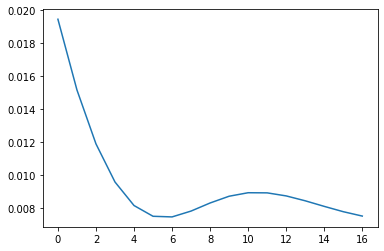

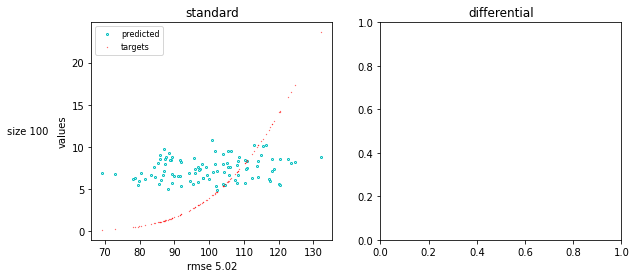

In [ ]:
model, loss = run_train(
          name = graph_name,
          generator = generator, with_derivative = False, 
          model_class = MLP_Relu, 
          model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, 
                          "hidden_layers" : N_HIDDEN, "out_features": 1}
)

### **2.2.2) Sobolev Training**

Epoch 0: train loss: 0.013270766474306583, y loss : 0.00729675218462944, dy loss : 0.005974014289677143
Epoch 1: train loss: 0.013137085363268852, y loss : 0.0074508353136479855, dy loss : 0.0056862495839595795
Epoch 2: train loss: 0.01306900940835476, y loss : 0.007466224487870932, dy loss : 0.005602785386145115
Epoch 3: train loss: 0.012875116430222988, y loss : 0.007269876077771187, dy loss : 0.005605240352451801
Epoch 4: train loss: 0.012783389538526535, y loss : 0.0071533676236867905, dy loss : 0.005630022380501032
Epoch 5: train loss: 0.012760018929839134, y loss : 0.0071395025588572025, dy loss : 0.005620516370981932
Epoch 6: train loss: 0.012687873095273972, y loss : 0.007130727171897888, dy loss : 0.005557145923376083
Epoch 7: train loss: 0.012571115978062153, y loss : 0.0071192542091012, dy loss : 0.005451861768960953
Epoch 8: train loss: 0.012491630390286446, y loss : 0.007145733572542667, dy loss : 0.005345896817743778
Epoch 9: train loss: 0.012445500120520592, y loss : 0.0

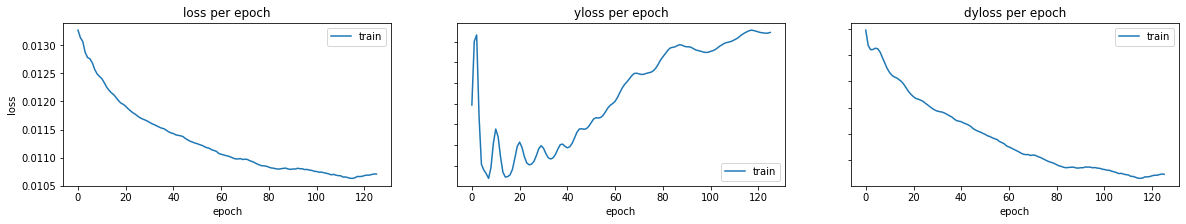

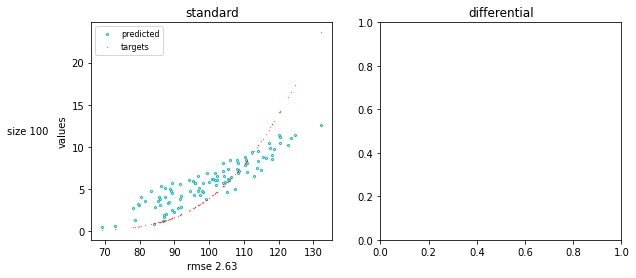

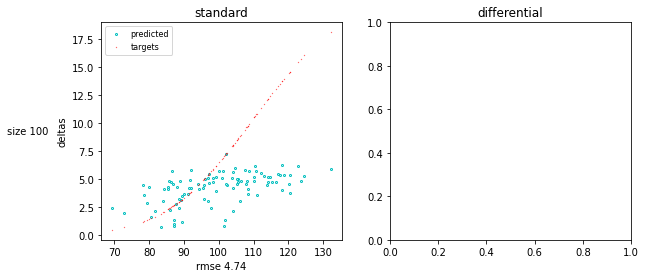

In [ ]:
model, loss = run_train(
          name = graph_name,
          generator = generator, with_derivative = True, 
          model_class = MLP_Relu, 
          model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, 
                          "hidden_layers" : N_HIDDEN, "out_features": 1}
)

### **2.2.3) SIREN**

Epoch 0: train loss: 0.039827197790145874, y loss : 0.02842099219560623, dy loss : 0.011406207457184792
Epoch 1: train loss: 0.014979048632085323, y loss : 0.007711529731750488, dy loss : 0.007267518900334835
Epoch 2: train loss: 0.014455404132604599, y loss : 0.010552681982517242, dy loss : 0.0039027216844260693
Epoch 3: train loss: 0.012252495624125004, y loss : 0.010422579944133759, dy loss : 0.0018299153307452798
Epoch 4: train loss: 0.009863228537142277, y loss : 0.008083582855761051, dy loss : 0.0017796455649659038
Epoch 5: train loss: 0.009486004710197449, y loss : 0.007240484468638897, dy loss : 0.0022455197758972645
Epoch 6: train loss: 0.00991218164563179, y loss : 0.007760042790323496, dy loss : 0.002152139088138938
Epoch 7: train loss: 0.009698080830276012, y loss : 0.00804226752370596, dy loss : 0.001655813306570053
Epoch 8: train loss: 0.008973142132163048, y loss : 0.007716572377830744, dy loss : 0.0012565701035782695
Epoch 9: train loss: 0.008431212045252323, y loss : 0

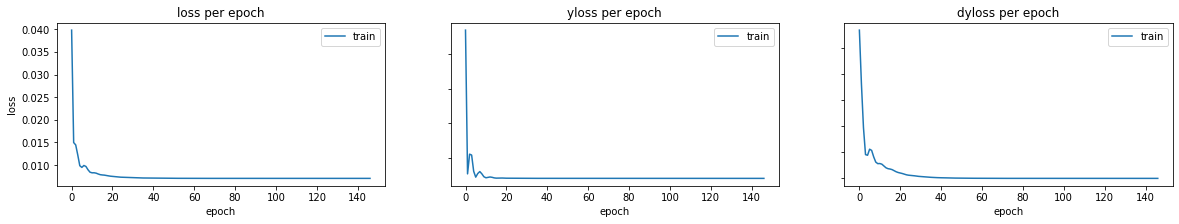

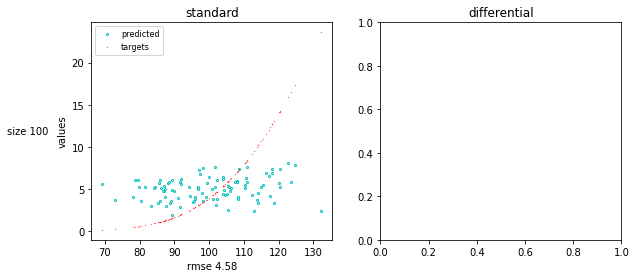

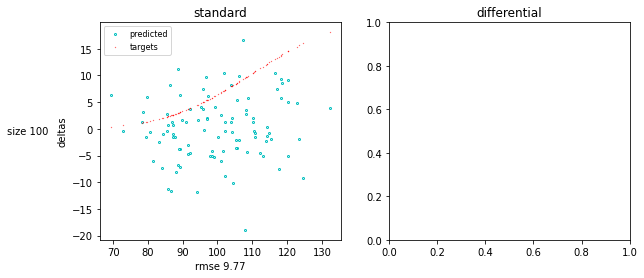

In [ ]:
model, loss = run_train(
          name = graph_name,
          generator = generator, with_derivative = True, 
          model_class = tf_Siren, 
          model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, 
                          "hidden_layers" : N_HIDDEN, "out_features": 1,
                          "outermost_linear" : True}
)

### **2.2.4) Differential ML**

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100



standard_yloss : 0.00079060503
standard_dyloss : 0.0017991647
differential_yloss : 0.00018529654
differential_dyloss : 0.0003726692
[[0.00079060503], [0.0017991647], [0.00018529654], [0.0003726692]]


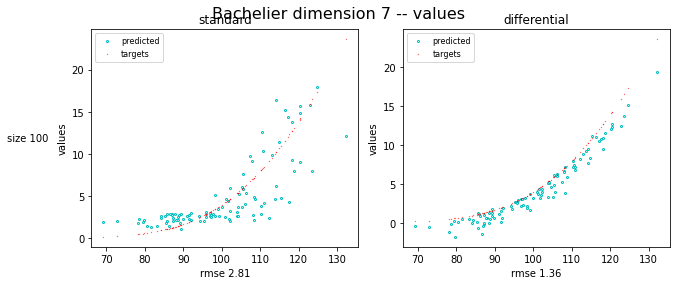

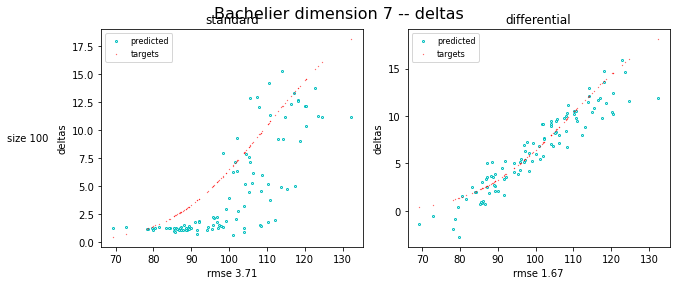

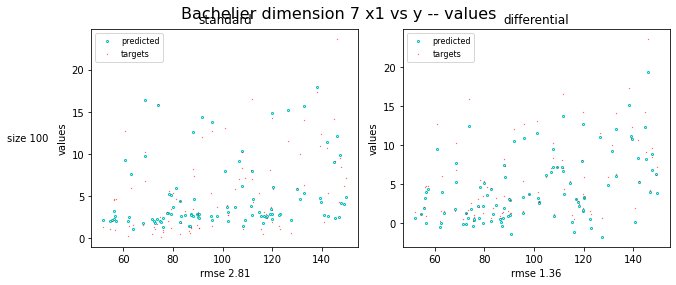

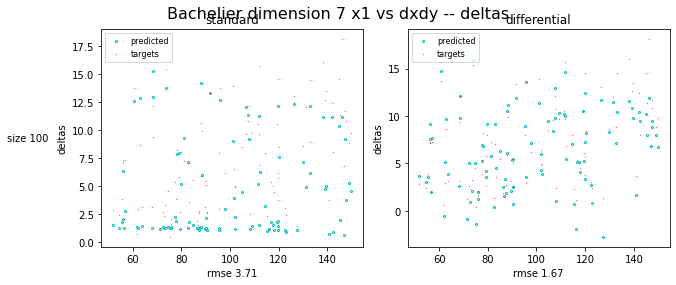

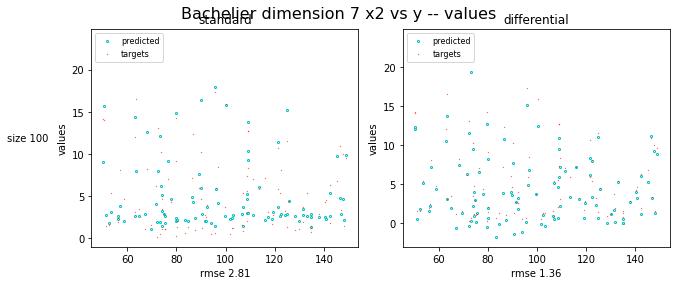

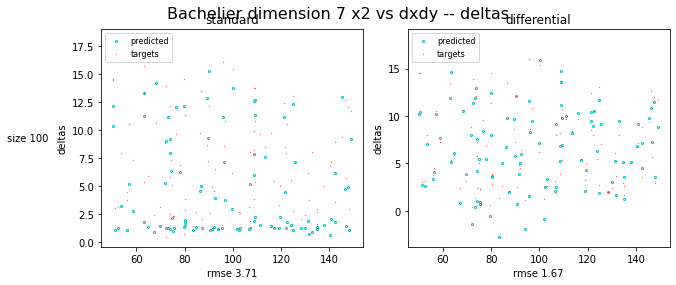

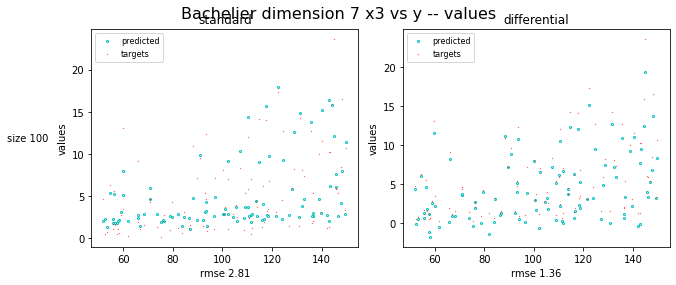

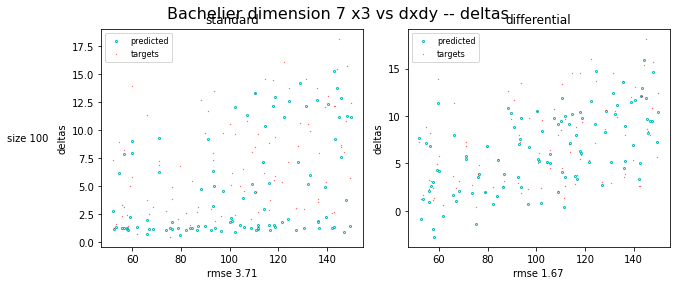

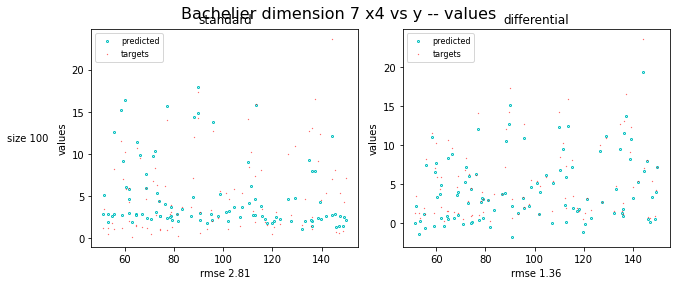

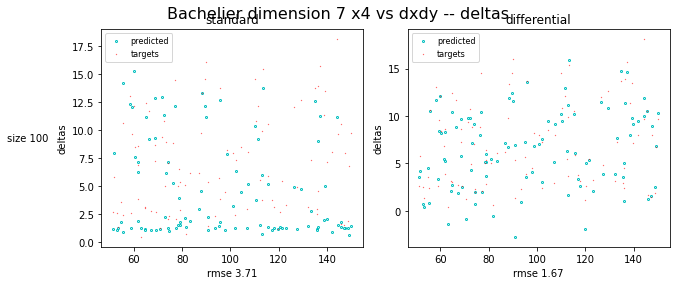

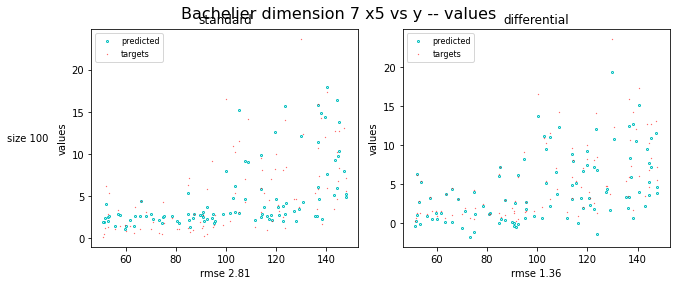

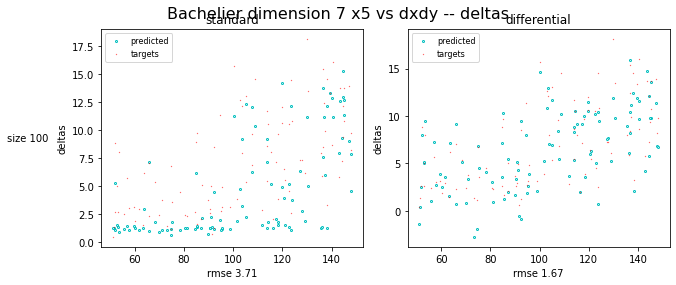

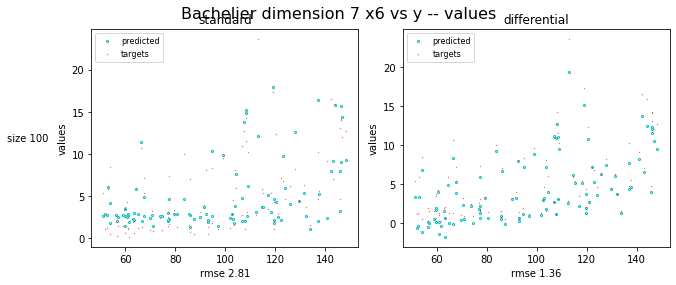

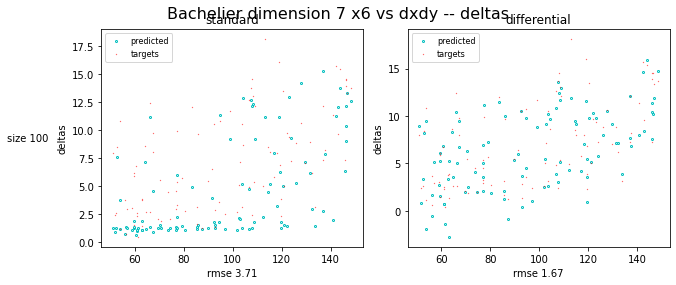

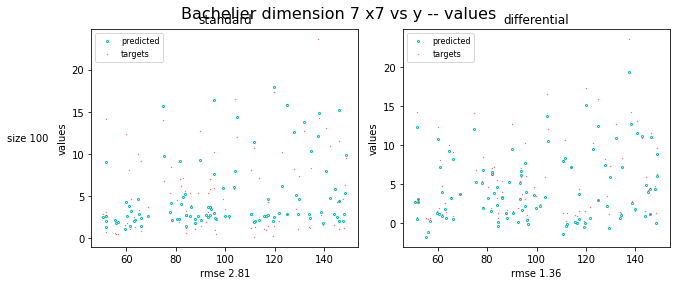

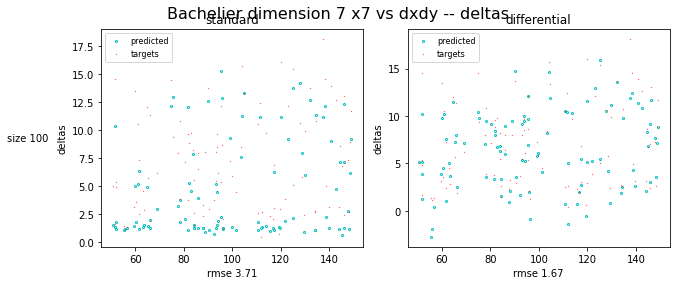

In [ ]:
model, loss = run_diffML_train(
              name = graph_name, 
              generator = generator, 
              generator_kwargs = {"hidden_units" : HIDDEN_DIM, "hidden_layers" : N_HIDDEN},
              show_graph_per_axis = True, 
              input_dim = INPUT_DIM)

### **2.2.5) twin_net with siren**

Epoch 0: train loss: 293.9323381728846, y loss : 1.0024793622445087, dy loss : 586.8621969835248
Epoch 1: train loss: 350.86068489300493, y loss : 1.0006675987827534, dy loss : 700.7207021872271
Epoch 2: train loss: 362.2172278751032, y loss : 1.0005442165598577, dy loss : 723.4339115336466
Epoch 3: train loss: 359.2083353262206, y loss : 1.000524220417957, dy loss : 717.4161464320233
Epoch 4: train loss: 376.7522575830205, y loss : 1.0004817375114985, dy loss : 752.5040334285295
Epoch 5: train loss: 384.9142247050043, y loss : 1.0004446986986666, dy loss : 768.82800471131
Epoch 6: train loss: 376.3014079123592, y loss : 1.0004023915650893, dy loss : 751.6024134331533
Epoch 7: train loss: 367.7418047898425, y loss : 1.0003840479315544, dy loss : 734.4832255317534
Epoch 8: train loss: 347.6722040984699, y loss : 1.0003410158108692, dy loss : 694.3440671811288
Epoch 9: train loss: 358.39775288507144, y loss : 1.0002981728436995, dy loss : 715.7952075972992
Epoch 10: train loss: 343.46157

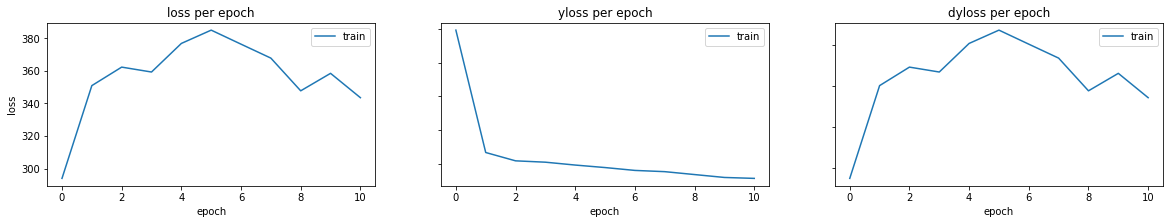

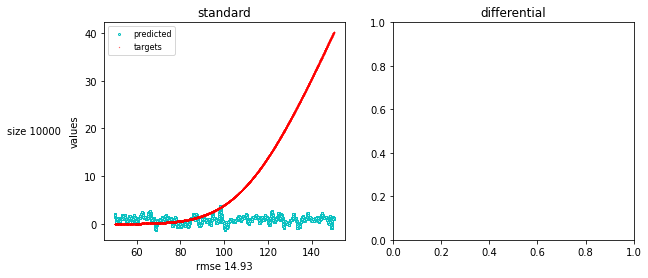

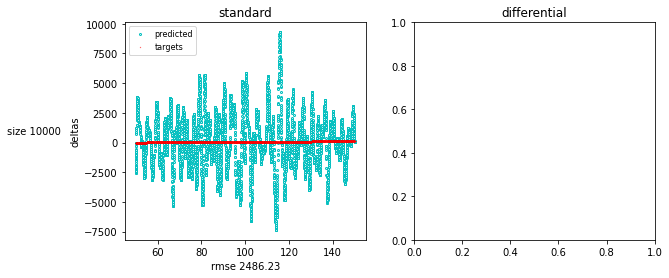

In [ ]:
model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, "hidden_layers" : N_HIDDEN, 
                "out_features": 1, "outermost_linear" : False, "first_omega_0" : 30, "hidden_omega_0" : 30.}
                
with_derivative = True
twinNet, loss = run_twinNet_train(graph_name, generator, with_derivative, model_class = Siren, model_kwargs = model_kwargs, deltidx = 0)

### **2.2.6) twin_net with MLP**

Epoch 0: train loss: 0.01721820794045925, y loss : 0.011511370539665222, dy loss : 0.005706836935132742
Epoch 1: train loss: 0.017743440344929695, y loss : 0.01203896664083004, dy loss : 0.0057044741697609425
Epoch 2: train loss: 0.01603633165359497, y loss : 0.010331669822335243, dy loss : 0.005704662296921015
Epoch 3: train loss: 0.013172665610909462, y loss : 0.007467207498848438, dy loss : 0.005705458112061024
Epoch 4: train loss: 0.014391982927918434, y loss : 0.00868605263531208, dy loss : 0.005705930292606354
Epoch 5: train loss: 0.015214638784527779, y loss : 0.009508632123470306, dy loss : 0.005706006195396185
Epoch 6: train loss: 0.013881132006645203, y loss : 0.00817541778087616, dy loss : 0.005705714225769043
Epoch 7: train loss: 0.012963620945811272, y loss : 0.007258489262312651, dy loss : 0.005705131683498621
Epoch 8: train loss: 0.01361205242574215, y loss : 0.007907504215836525, dy loss : 0.005704548209905624
Epoch 9: train loss: 0.014269677922129631, y loss : 0.008565

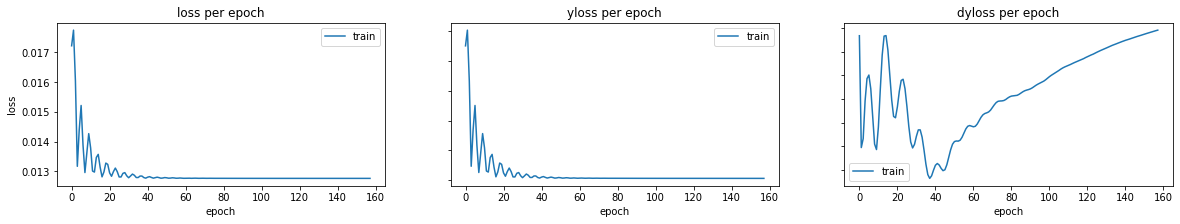

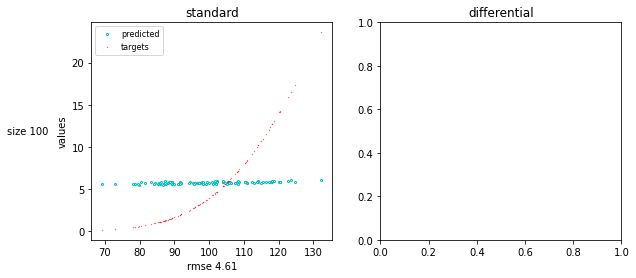

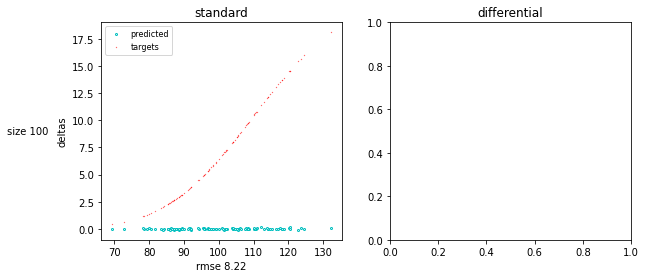

In [ ]:
model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, "hidden_layers" : N_HIDDEN, 
                "out_features": 1, 
                "activation_function" : F.softplus, # This is what was done in the original code.
                "deriv_activation_function" : F.sigmoid
                }
                
with_derivative = True
twinNet, loss = run_twinNet_train(graph_name, generator, with_derivative, model_class = MLP, model_kwargs = model_kwargs, deltidx = 0)

## **2.3) Bachelier dimension 20**

In [ ]:
INPUT_DIM = 20
generator = Bachelier(n = INPUT_DIM)
graph_name = "Bachelier dimension %d" % INPUT_DIM

### **2.3.1) Normal Training**

Epoch 0: train loss: 0.007565896026790142
Epoch 1: train loss: 0.007654077839106321
Epoch 2: train loss: 0.00749377952888608
Epoch 3: train loss: 0.007387563120573759
Epoch 4: train loss: 0.007437937892973423
Epoch 5: train loss: 0.007428701967000961
Epoch 6: train loss: 0.007352696266025305
Epoch 7: train loss: 0.007319334428757429
Epoch 8: train loss: 0.007343240547925234
Epoch 9: train loss: 0.00735102454200387
Epoch 10: train loss: 0.007317010313272476
Epoch 11: train loss: 0.0072837709449231625
Epoch 12: train loss: 0.007283905986696482
Epoch 13: train loss: 0.007297911681234837
Epoch 14: train loss: 0.007292045745998621
Epoch 15: train loss: 0.007269150577485561
Epoch 16: train loss: 0.0072560785338282585
Epoch 17: train loss: 0.007261865772306919
Epoch 18: train loss: 0.007268688175827265
Epoch 19: train loss: 0.007261382881551981
Epoch 20: train loss: 0.007247960660606623
Epoch 21: train loss: 0.007243880536407232
Epoch 22: train loss: 0.007249466609209776
Epoch 23: train loss:

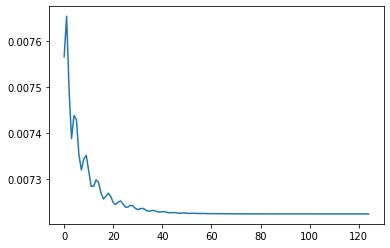

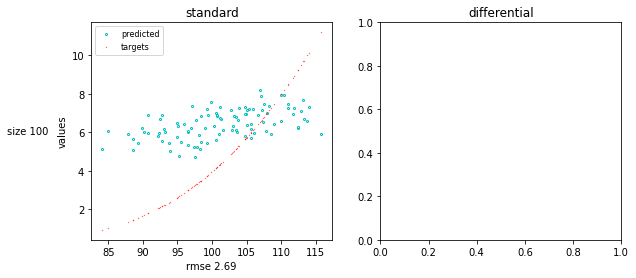

In [ ]:
model, loss = run_train(
          name = graph_name,
          generator = generator, with_derivative = False, 
          model_class = MLP_Relu, 
          model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, 
                          "hidden_layers" : N_HIDDEN, "out_features": 1}
)

### **2.3.2) Sobolev Training**


Epoch 0: train loss: 0.012182577513158321, y loss : 0.011323994025588036, dy loss : 0.0008585830801166594
Epoch 1: train loss: 0.009610279463231564, y loss : 0.008785651996731758, dy loss : 0.0008246270590461791
Epoch 2: train loss: 0.008475345559418201, y loss : 0.007680946495383978, dy loss : 0.00079439947148785
Epoch 3: train loss: 0.008492954075336456, y loss : 0.007724089082330465, dy loss : 0.0007688652840442955
Epoch 4: train loss: 0.008998794481158257, y loss : 0.008247645571827888, dy loss : 0.0007511484436690807
Epoch 5: train loss: 0.009317057207226753, y loss : 0.008577900007367134, dy loss : 0.0007391571998596191
Epoch 6: train loss: 0.009250795468688011, y loss : 0.008515960536897182, dy loss : 0.0007348348153755069
Epoch 7: train loss: 0.008926887065172195, y loss : 0.008190764114260674, dy loss : 0.0007361225434578955
Epoch 8: train loss: 0.008540097624063492, y loss : 0.007800434250384569, dy loss : 0.000739663140848279
Epoch 9: train loss: 0.008246641606092453, y loss

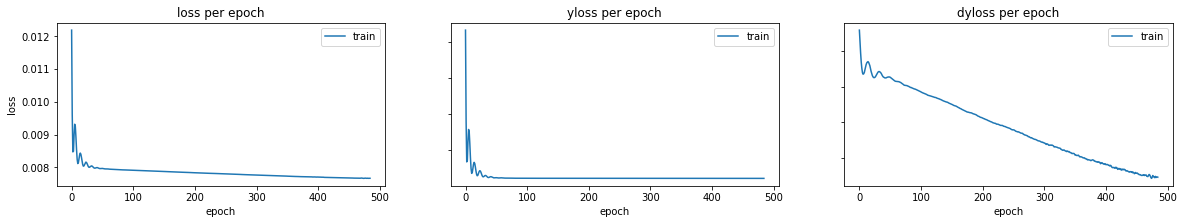

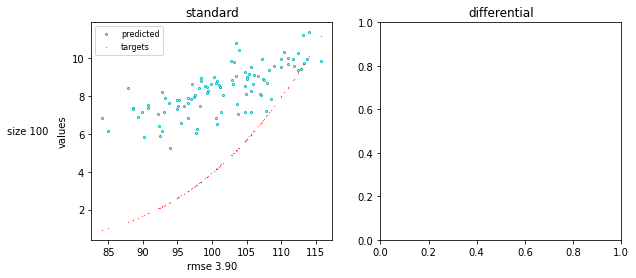

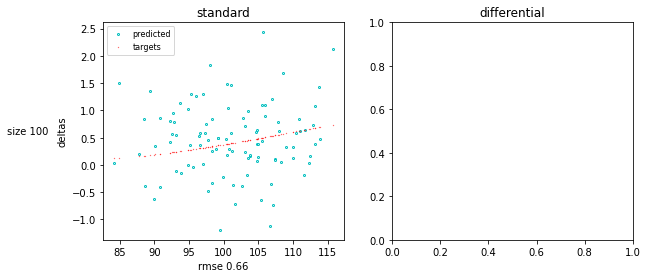

In [ ]:
model, loss = run_train(
          name = graph_name,
          generator = generator, with_derivative = True, 
          model_class = MLP_Relu, 
          model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, 
                          "hidden_layers" : N_HIDDEN, "out_features": 1}
)

### **2.3.3) SIREN**


Epoch 0: train loss: 0.020883403718471527, y loss : 0.019317079335451126, dy loss : 0.0015663248486816883
Epoch 1: train loss: 0.009837315417826176, y loss : 0.008337310515344143, dy loss : 0.0015000052517279983
Epoch 2: train loss: 0.013533246703445911, y loss : 0.012254467234015465, dy loss : 0.0012787794694304466
Epoch 3: train loss: 0.010549687780439854, y loss : 0.009470409713685513, dy loss : 0.0010792778339236975
Epoch 4: train loss: 0.00832848995923996, y loss : 0.0073615387082099915, dy loss : 0.000966951425652951
Epoch 5: train loss: 0.009421999566257, y loss : 0.008516254834830761, dy loss : 0.0009057449642568827
Epoch 6: train loss: 0.01002566423267126, y loss : 0.009210141375660896, dy loss : 0.0008155232644639909
Epoch 7: train loss: 0.008968153037130833, y loss : 0.008266734890639782, dy loss : 0.0007014177390374243
Epoch 8: train loss: 0.007972504012286663, y loss : 0.007377319503575563, dy loss : 0.0005951846251264215
Epoch 9: train loss: 0.00799773819744587, y loss : 

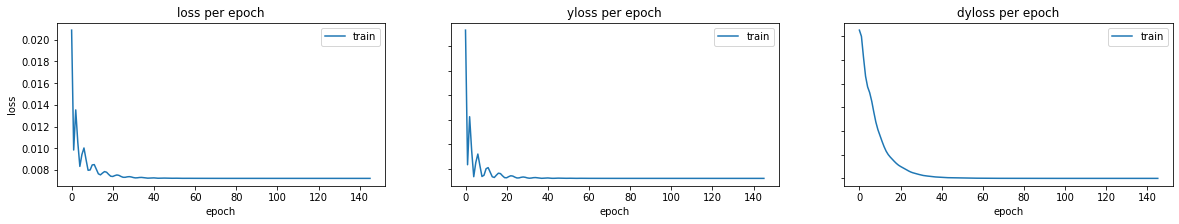

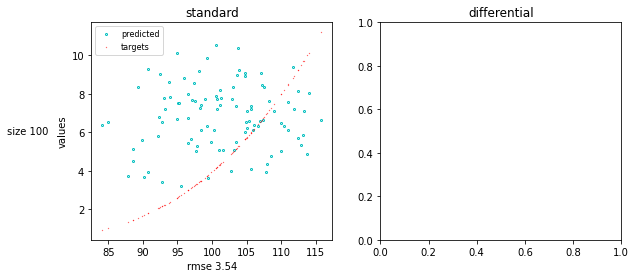

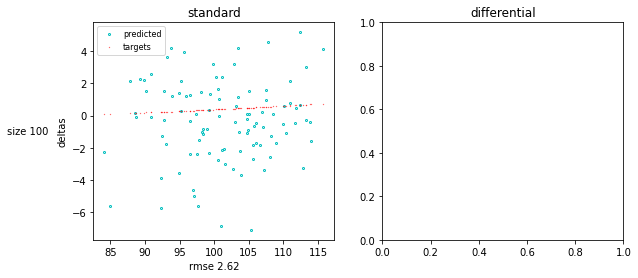

In [ ]:
model, loss = run_train(
          name = graph_name,
          generator = generator, with_derivative = True, 
          model_class = tf_Siren, 
          model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, 
                          "hidden_layers" : N_HIDDEN, "out_features": 1,
                          "outermost_linear" : True}
)

### **2.3.4) Differential ML**

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100



standard_yloss : 0.00058202876
standard_dyloss : 0.0004036992
differential_yloss : 2.9484818e-05
differential_dyloss : 3.147654e-05
[[0.00058202876], [0.0004036992], [2.9484818e-05], [3.147654e-05]]


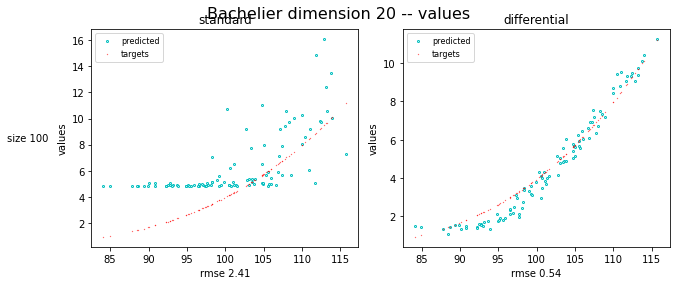

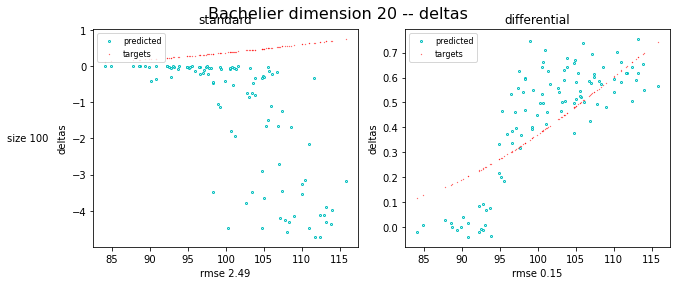

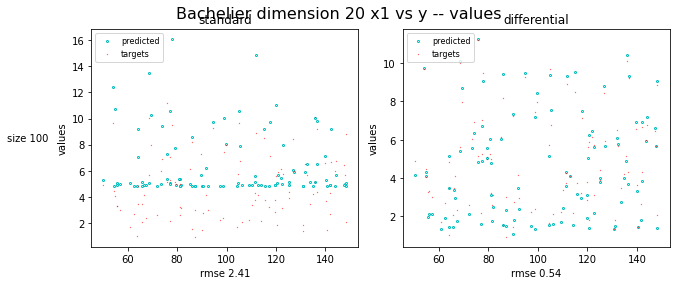

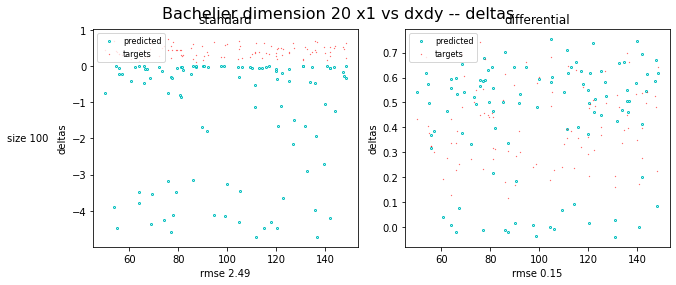

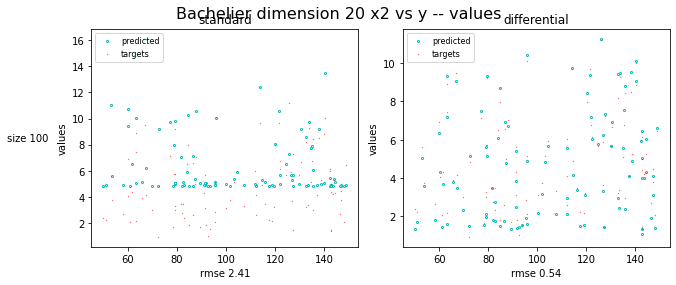

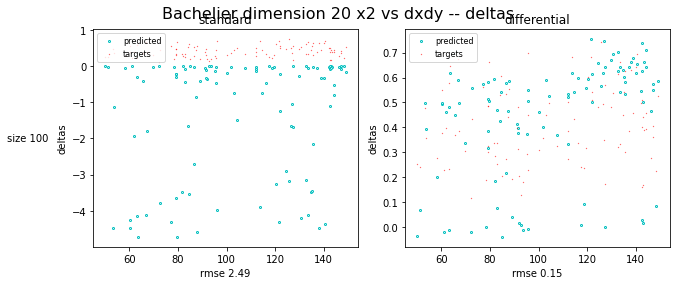

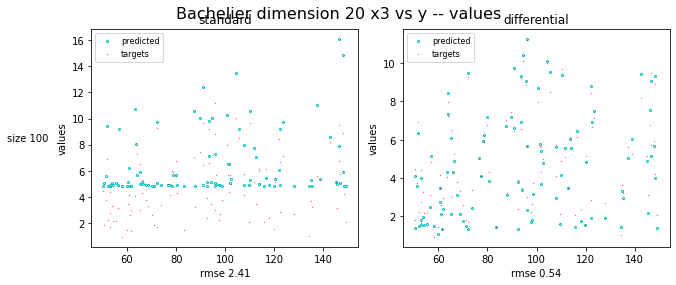

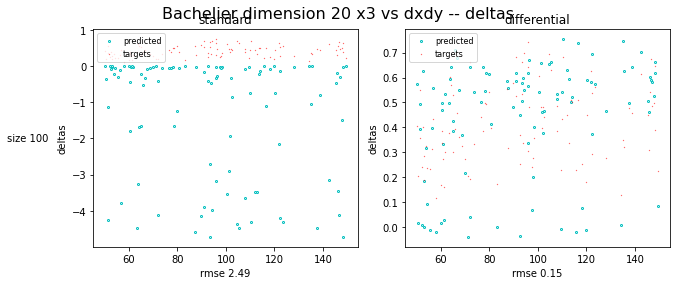

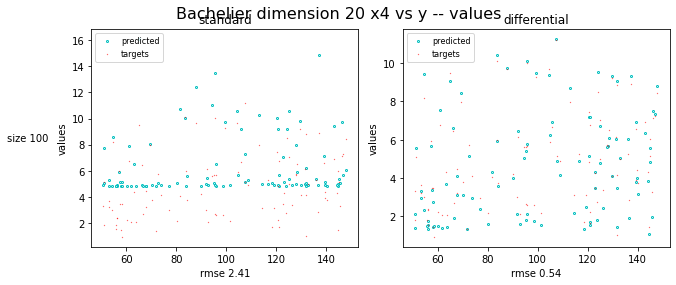

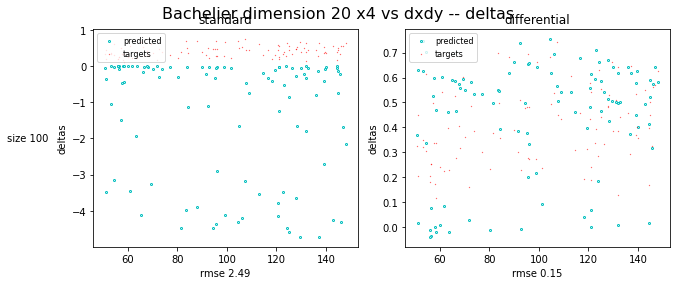

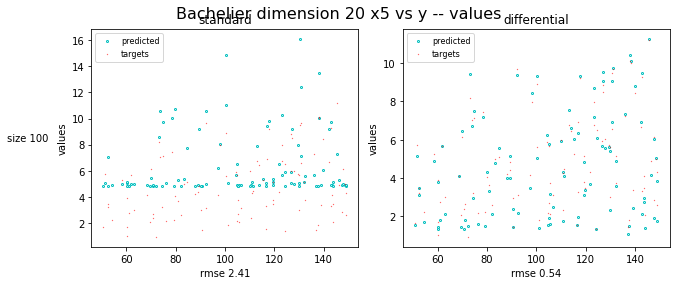

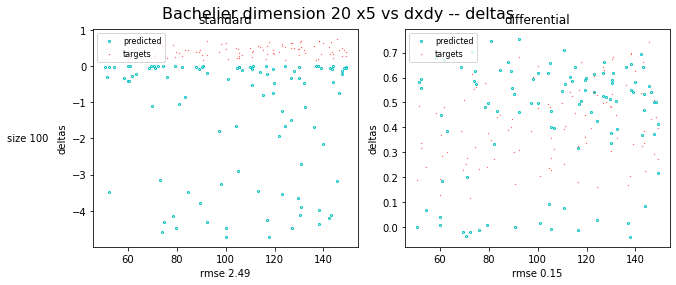

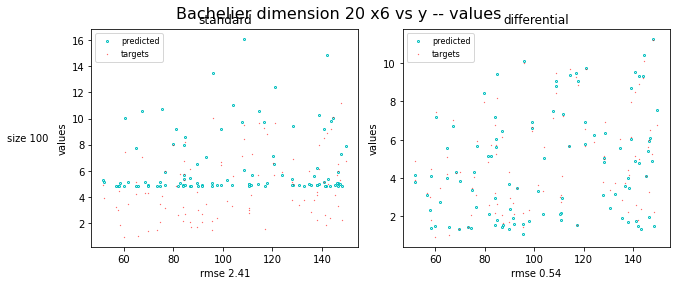

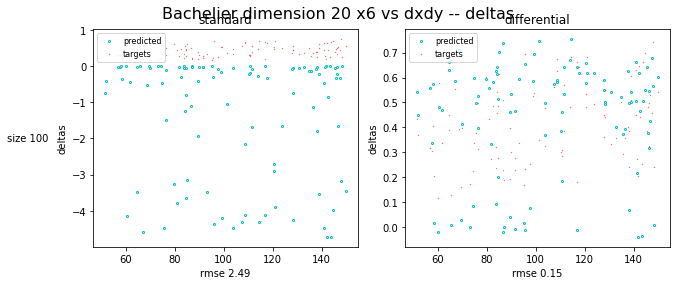

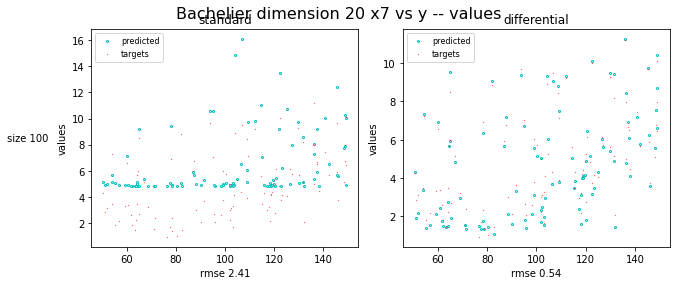

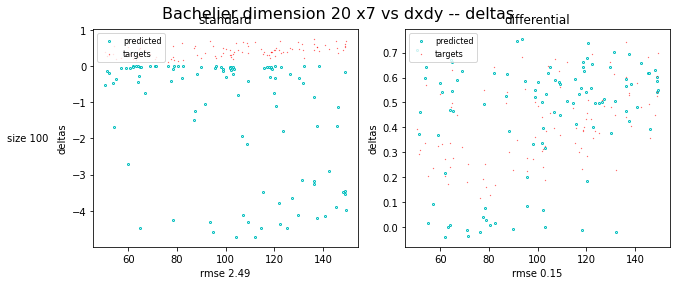

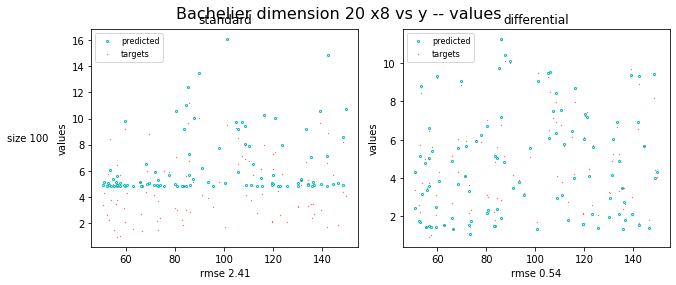

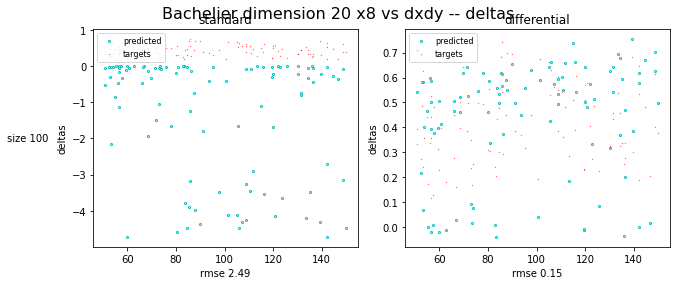

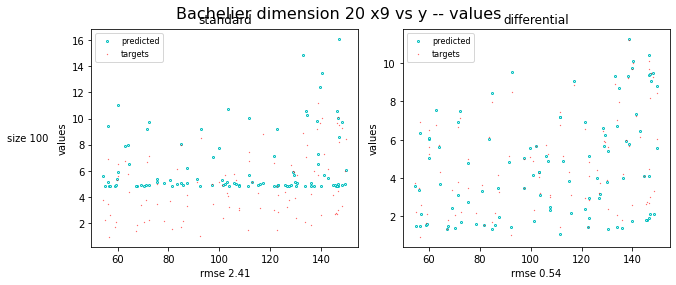

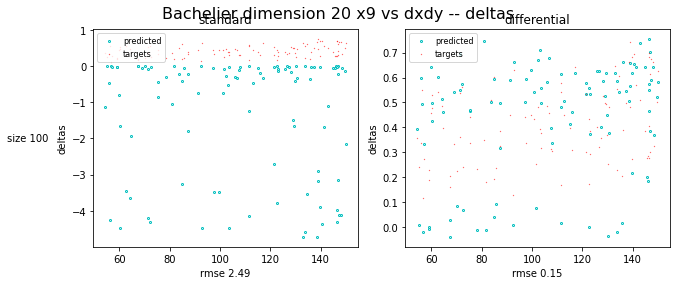

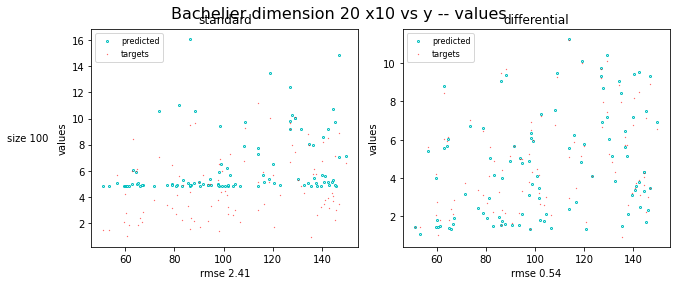

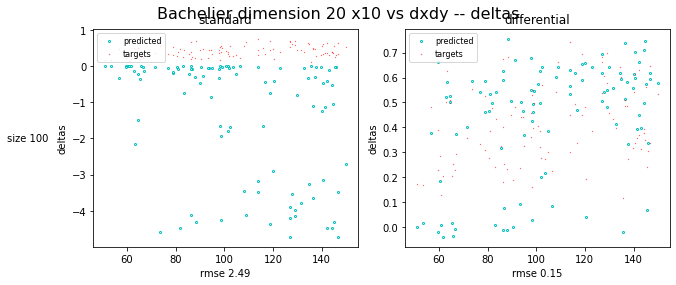

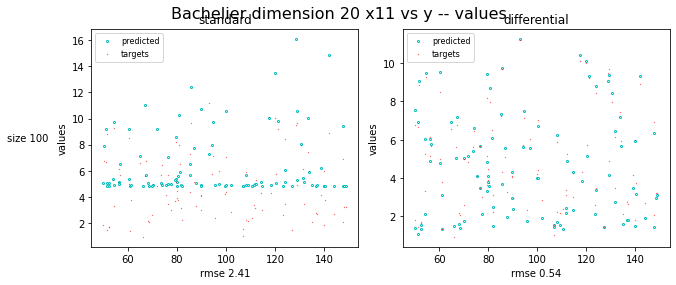

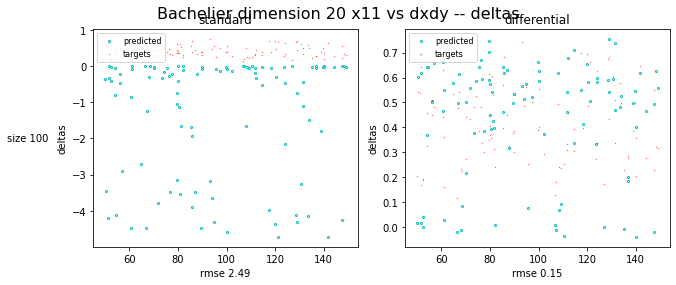

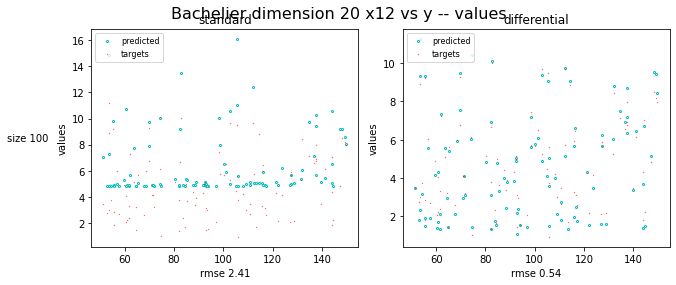

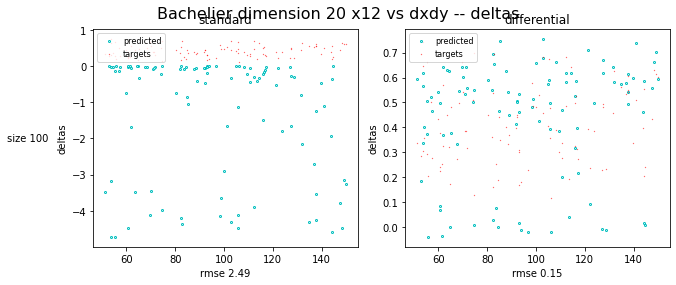

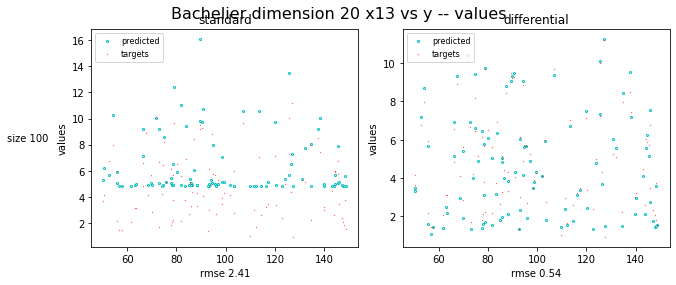

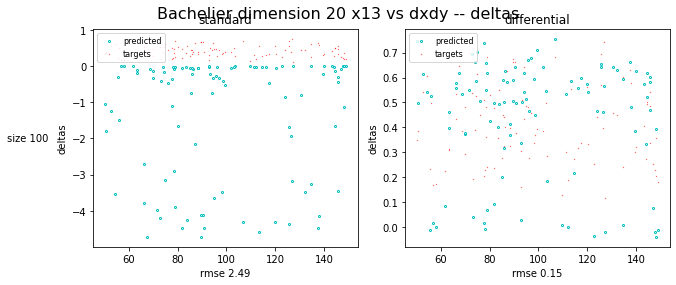

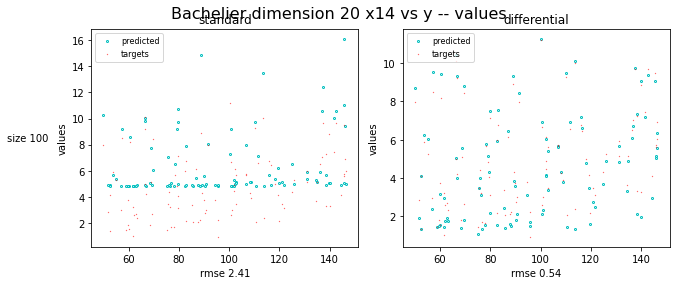

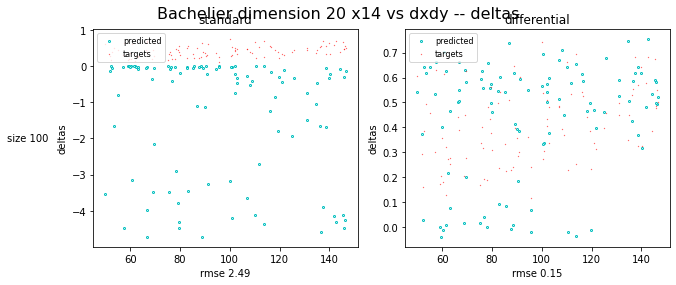

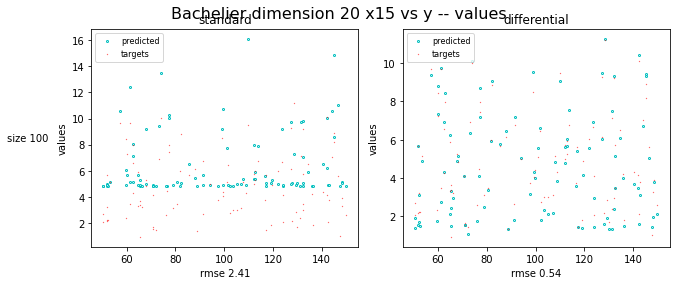

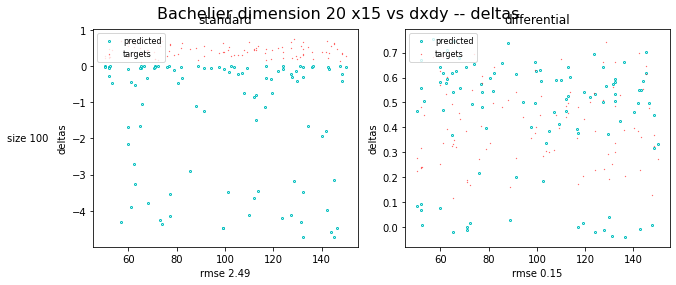

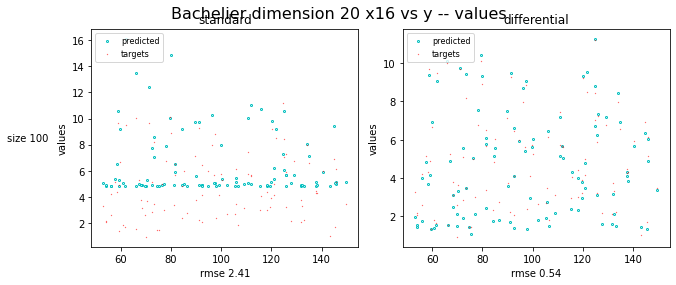

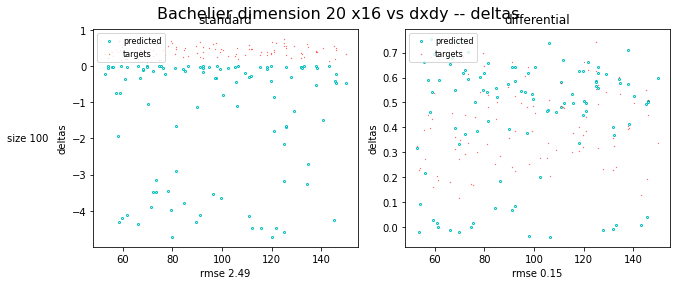

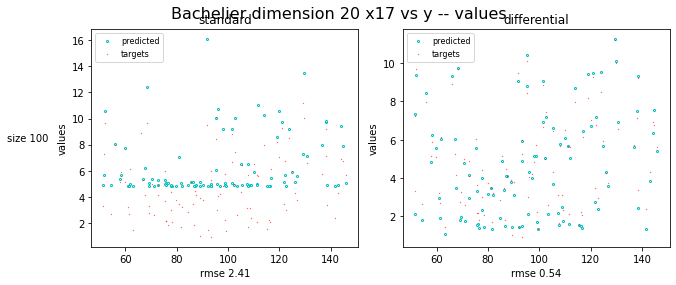

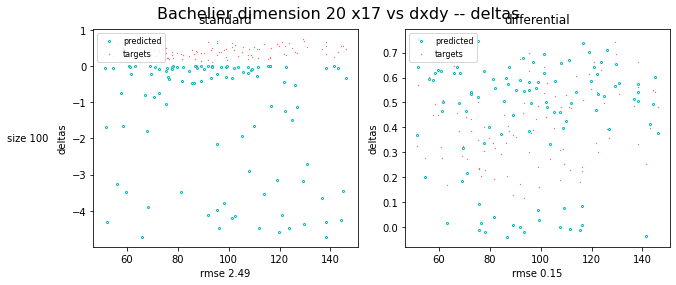

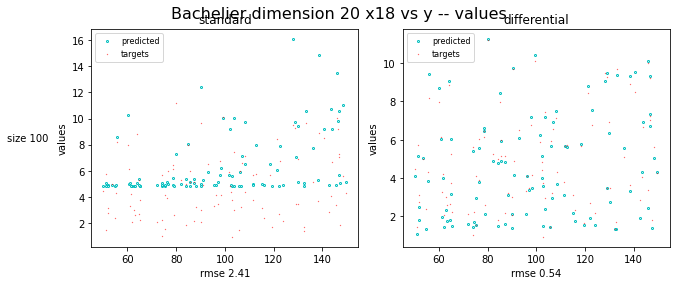

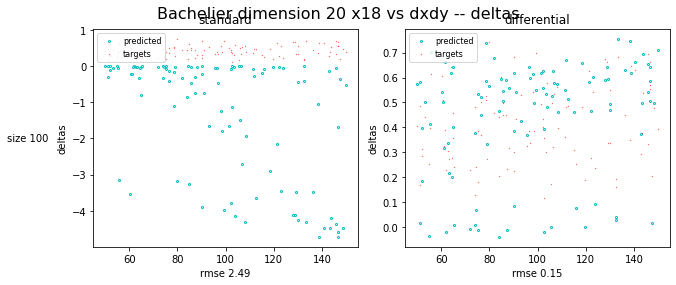

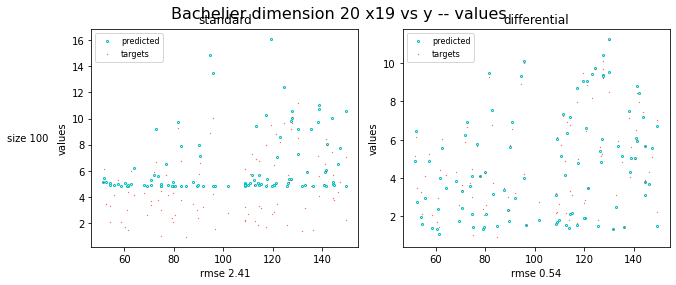

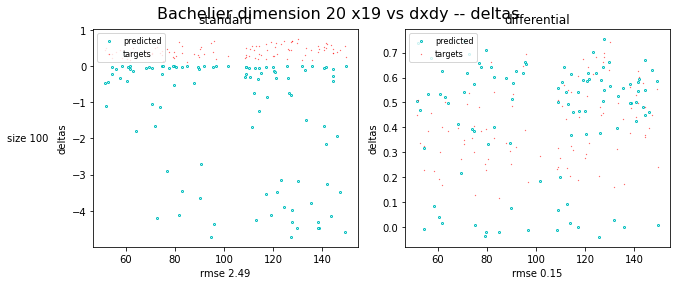

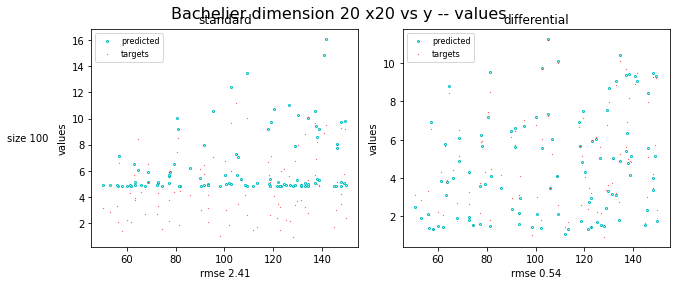

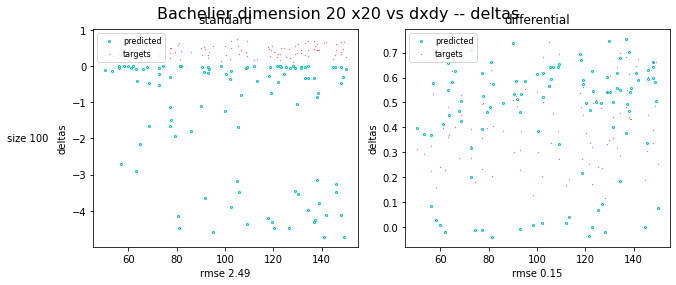

In [ ]:
model, loss = run_diffML_train(
              name = graph_name, 
              generator = generator, 
              generator_kwargs = {"hidden_units" : HIDDEN_DIM, "hidden_layers" : N_HIDDEN},
              show_graph_per_axis = True, 
              input_dim = INPUT_DIM)

### **2.3.5) twin_net with siren**

Epoch 0: train loss: 5.46977424621582, y loss : 1.2350273132324219, dy loss : 4.234746932983398
Epoch 1: train loss: 12.747625350952148, y loss : 8.315074920654297, dy loss : 4.432549953460693
Epoch 2: train loss: 5.218028545379639, y loss : 0.8030752539634705, dy loss : 4.414953231811523
Epoch 3: train loss: 6.0141448974609375, y loss : 1.5061988830566406, dy loss : 4.507946014404297
Epoch 4: train loss: 7.688776016235352, y loss : 3.1275336742401123, dy loss : 4.56124210357666
Epoch 5: train loss: 6.299102306365967, y loss : 1.6897817850112915, dy loss : 4.609320640563965
Epoch 6: train loss: 4.947995185852051, y loss : 0.2491665482521057, dy loss : 4.69882869720459
Epoch 7: train loss: 5.11476469039917, y loss : 0.29246819019317627, dy loss : 4.822296619415283
Epoch 8: train loss: 5.9043779373168945, y loss : 0.9883654117584229, dy loss : 4.916012763977051
Epoch 9: train loss: 6.0052618980407715, y loss : 1.0712910890579224, dy loss : 4.933970928192139
Epoch 10: train loss: 5.448746

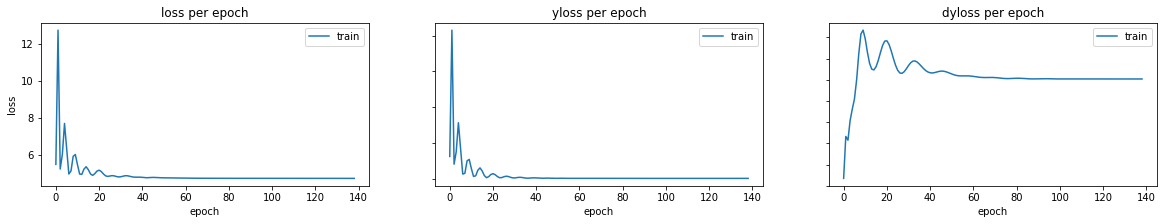

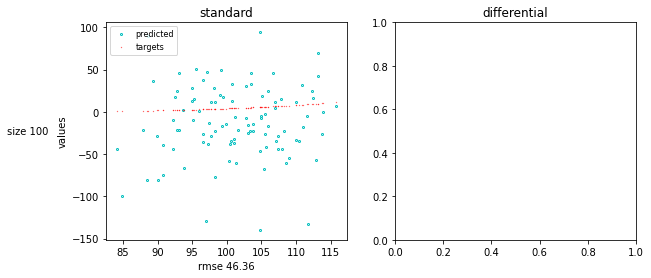

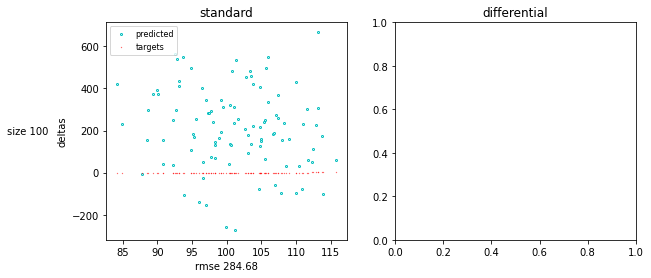

In [ ]:
model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, "hidden_layers" : N_HIDDEN, 
                "out_features": 1, "outermost_linear" : False, "first_omega_0" : 30, "hidden_omega_0" : 30.}
                
with_derivative = True
twinNet, loss = run_twinNet_train(graph_name, generator, with_derivative, model_class = Siren, model_kwargs = model_kwargs, deltidx = 0)

### **2.3.6) twin_net with MLP**

Epoch 0: train loss: 0.08434302359819412, y loss : 0.08359181135892868, dy loss : 0.0007512087468057871
Epoch 1: train loss: 0.03561875596642494, y loss : 0.034866515547037125, dy loss : 0.0007522403029724956
Epoch 2: train loss: 0.018858319148421288, y loss : 0.018105020746588707, dy loss : 0.0007532978779636323
Epoch 3: train loss: 0.023437324911355972, y loss : 0.02268325164914131, dy loss : 0.0007540735532529652
Epoch 4: train loss: 0.031235408037900925, y loss : 0.03048103302717209, dy loss : 0.0007543744286522269
Epoch 5: train loss: 0.031779296696186066, y loss : 0.031025027856230736, dy loss : 0.0007542686071246862
Epoch 6: train loss: 0.025722146034240723, y loss : 0.02496827021241188, dy loss : 0.0007538759964518249
Epoch 7: train loss: 0.01759645715355873, y loss : 0.016843156889081, dy loss : 0.0007533000316470861
Epoch 8: train loss: 0.011408013291656971, y loss : 0.010655388236045837, dy loss : 0.0007526254048570991
Epoch 9: train loss: 0.009161783382296562, y loss : 0.00

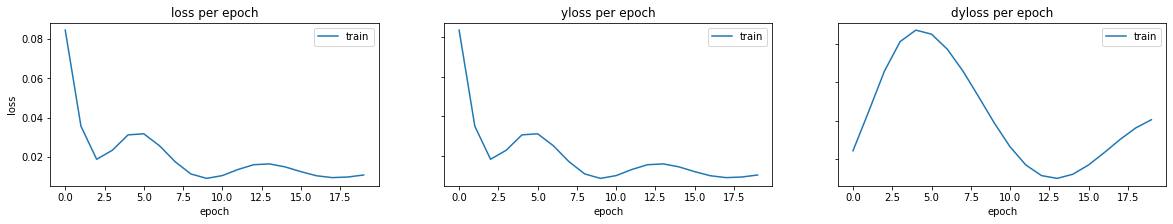

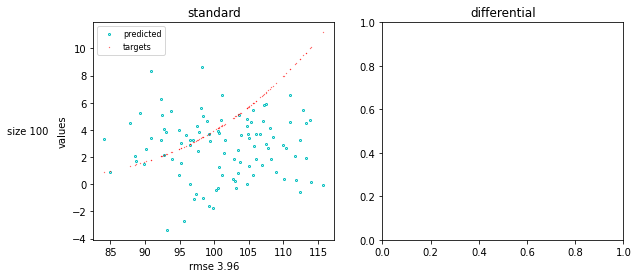

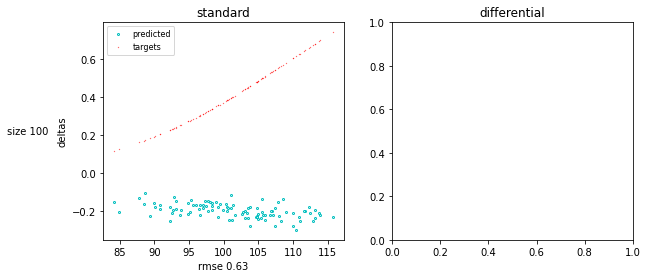

In [ ]:
model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, "hidden_layers" : N_HIDDEN, 
                "out_features": 1, 
                "activation_function" : F.softplus, # This is what was done in the original code.
                "deriv_activation_function" : F.sigmoid
                }
                
with_derivative = True
twinNet, loss = run_twinNet_train(graph_name, generator, with_derivative, model_class = MLP, model_kwargs = model_kwargs, deltidx = 0)